## Modelling Time Series: Data Extraction, Processing and Visualization of Independent Variables

In [2]:
# data fetching and manipulation
from fredapi import Fred
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import requests
import pandas_ta
import matplotlib.pyplot as plt

# statistics
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.decomposition import PCA
from pmdarima.arima import auto_arima
from scipy.stats import shapiro, normaltest, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, roc_auc_score, r2_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from fbprophet import Prophet
from hampel import hampel
from xgboost import XGBRegressor

# ssl issues
import ssl 
try:
    _create_unverified_https_context = ssl._create_unverified_context 
except AttributeError: 
    pass 
else: 
    ssl._create_default_https_context = _create_unverified_https_context

# progress bar
from tqdm.notebook import tqdm
from IPython.display import clear_output

# Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("deprecated", DeprecationWarning)

/opt/homebrew/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Predictive algorithms for stock valuation

## 1) Features - independent variables

### Technical indicators

Stock market investing fundamentals:
* bollinger bands
* moving average, exponentially weighted
* parabolic stop & reverse
* relative strength indicator
* stochastic oscillator

Material: *Understanding Indicators in Technical Analysis* (2020) Charles D. Kirkpatrick
    
### Macroeconomics indicators

Although macroeconomics are often used for the money market and the debt market, we will test to establish significance of macro indicators in the stock market

An assumption is that stock prices are significantly influenced by irrational waves of optimism and pessimism among investors, hence we expect macro indicators to weigh less in the stock prediction

Indicators are as follow:
* Inflation 
* Money supply
* Interest rates
* Unemployment
* Balance of payments
* Value of currency
* Business cycle
* Gold price

Material: *Macroeconomic indicators and capital market performance: Are the links sustainable?* (2020) Felicia O. Olokoyo

*Monte Carlo Simulation in Financial Valuation* (2014) Magnus Erik Hvass Pedersen

*Chapter 5: Stock Valuation* Professor Thomson

## 2) Benchmark models

### Benchmark 1- Classic ML models

* Linear Regression
* Random Forest Regressor
* XGBoost 

### Benchmark 2- Recurrent Neural Network (RNN) - Long short term memory (LSTM) 

* LSTM has three gates, and number of LSTM layers, dropout value, and number of epochs can be tweaked
* Input gate: adds information to the cell state
* Forget gate: removes the information that is no longer required by the model
* Output gate: selects the information to be shown as output
* *Stock Market prediction using CNN-LSTM* (2021) Adhitya A

### Benchmark 3- Genetic algorithms - NeuroEvolution of Augmented Topologies (NEAT)

* Genotype initialization -> (evaluation -> crossover & mutation) for x generations
* Define number of inputs, hidden, and output layers, along with bias values
* Weight space explored via crossover of network weights and mutation of a single network's weight
* Fitness function
* *Prediction the stock market with genetic programming* (2017) David Moskowitz
* Github NEAT MattKallada

### Benchmark 4- Auto Regressive Integrated Moving Average (ARIMA)

* Cointegration test
* (p) selection of VAR(p) model with Partial AutoCorrelation Function (PACF)
* Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
* *Vector Autoregression (VAR) Comprehensive Guide with Examples in Python* (2019) Selva Prabhakaran
* *Data Analysis, ML and applications* (2007) C.Preisach, H.Burkhardt, p.499-507

### Benchmark 5- Monte Carlo simulation

* Predicts the worst likely loss for a portfolio given a confidence interval over a specified time horizon
* Uses repeated random sampling to obtain the likelihood of a range of results of occurring
* Determine probability distributions and dependencies
* Determine the required number of Monte Carlo iterations
* *Stock Valuation using Monte Carlo Simulation and Statistical Analysis* (2020) Shreyas Khalkar, Neel Mehta


## 3) Other model specifications

### Statistics & time series analysis

* Gauss-Markov assumptions
* Test for stationarity (augmented dickey fuller)
* Test for seasonality (ljung-box, buys ballot table)
* Volatility decomposition aka forecast error variance decomposition (manova, mancova)
* Generalized Auto Regressive Conditional Heteroskedasticity (GARCH) for volatility
* Granger Causality (if X is correlated with Y with a lag of 5, we can't see it in correlation-ratio)
* Value at risk (VaR) with monte carlo simulation
* Log returns aka continuous compounded returns & log-linear approximations
* We need to use the natural log because we want the returns to be continuously compounded
* Lag length selection with Information Criterion, Akaike (AIC), Bayes (BIC) or Hannan-Quinn (HQC) 
* Standardised Residuals Tests: Jarque-Bera, Shapiro-Wilk, Ljung-Box
* Baum Welch, Dynamic Time Warping, Time series clustering

Material: 
* *A Guide to Modern Econometrics* (2004) Marno Verbeek
* *Lag Length Selection in Vector Autoregressive Models: Symmetric and Asymmetric Lags* Omer Ozcicek
* *Stock Market Volatility and Return Analysis: A Systematic Literature Review* (2020) Roni Bhowmik and Shouyang Wang
* *Python open source libraries for scaling time series forecasting solutions* (2021) Francesca Lazzeri

## 1) API Fetch

In [3]:
# get api key on fred and then input it as parameter 
fred = Fred(api_key='c0c638b17725352b38944335b73d1fe2')

In [34]:
fred.search('daily').T

series id                                                             T10Y2Y  \
id                                                                    T10Y2Y   
realtime_start                                           2022-03-02 00:00:00   
realtime_end                                             2022-03-02 00:00:00   
title                      10-Year Treasury Constant Maturity Minus 2-Yea...   
observation_start                                        1976-06-01 00:00:00   
observation_end                                          2022-03-01 00:00:00   
frequency                                                              Daily   
frequency_short                                                            D   
units                                                                Percent   
units_short                                                                %   
seasonal_adjustment                                  Not Seasonally Adjusted   
seasonal_adjustment_short                                                NSA   
last_updated                                       2022-03-01 16:02:04-06:00   
popularity                                                               100   
notes                      Starting with the update on June 21, 2019, the...   

series id                                                                DFF  \
id                                                                       DFF   
realtime_start                                           2022-03-02 00:00:00   
realtime_end                                             2022-03-02 00:00:00   
title                                           Federal Funds Effective Rate   
observation_start                                        1954-07-01 00:00:00   
observation_end                                          2022-02-28 00:00:00   
frequency                                                       Daily, 7-Day   
frequency_short                                                            D   
units                                                                Percent   
units_short                                                                %   
seasonal_adjustment                                  Not Seasonally Adjusted   
seasonal_adjustment_short                                                NSA   
last_updated                                       2022-03-01 15:17:29-06:00   
popularity                                                                82   
notes                      For additional historical federal funds rate d...   

series id                                                             T10YIE  \
id                                                                    T10YIE   
realtime_start                                           2022-03-02 00:00:00   
realtime_end                                             2022-03-02 00:00:00   
title                                       10-Year Breakeven Inflation Rate   
observation_start                                        2003-01-02 00:00:00   
observation_end                                          2022-03-01 00:00:00   
frequency                                                              Daily   
frequency_short                                                            D   
units                                                                Percent   
units_short                                                                %   
seasonal_adjustment                                  Not Seasonally Adjusted   
seasonal_adjustment_short                                                NSA   
last_updated                                       2022-03-01 16:01:15-06:00   
popularity                                                                95   
notes                      The breakeven inflation rate represents a meas...   

series id                                                       BAMLH0A0HYM2  \
id                                                              BAMLH0A0HYM2 

In [5]:
# get api key on fred website and input it as parameter 
fred = Fred(api_key='0c29c6d8d6d8733032c9ff87653f81a6')

# get description of macro-indicators, data frequency and  as string
initial_daily_indic = []
initial_daily_indic_descr = []
x = fred.search('daily').T.loc['title'] # get description of macro-indicators as string
y = fred.search('daily').T.loc['frequency'] # get data frequency as string (d,w,m,q)
z = fred.search('daily').T.columns # get codes of indicators

# create the dataframe with macro-indicators codes and their descriptions (will use a lot later)
for i, e in enumerate(y):
    if e=='Daily':
        initial_daily_indic.append(z[i]) 
        initial_daily_indic_descr.append(x[i])
indic = pd.DataFrame(initial_daily_indic, columns=['indic'])
descr = pd.DataFrame(initial_daily_indic_descr, columns=['descr'])
source = pd.concat([indic, descr], axis=1) # here you specify the number of indicators that you want

## 2) Missing Values

In [6]:
# fetch the macro-indicators data
df = pd.DataFrame()
df_temp = pd.DataFrame(pdr.DataReader(f'AAPL', 'yahoo', '2020-05-06','2022-02-02'))['Adj Close'] 

for index, element in enumerate(tqdm(source['indic'])): 
    data = fred.get_series(element, '2020-05-06', '2022-02-02')
    if (data.isnull().sum() > 22) or (data.isnull().sum() == 0): # if there are more than 25 NaNs we delete
        print(f'{index+1}) {element} has improper NaN values: ({data.isnull().sum()})')
        source.drop((index), inplace=True)
        pass
    elif (data.isnull().sum() <= 22) and (data.isnull().sum() != 0):
        print(f'{index+1}) {element} number of NaNs: {data.isnull().sum()}')
        df[element] = data
        
# concatenate indicators with stock price to delete stock price NaNs and interpolate indicators NaN
df = pd.concat([df_temp, df], axis=1)
print(df)
df = df.dropna(subset=['Adj Close']) # drop only stock price NaNs 
df.drop(['Adj Close'], axis=1, inplace=True) # drop initial stock info
df.interpolate('pad', inplace=True) # and interpolate rest (macro-indicators)
for e in df.columns:
    if df[e].isnull().values.any():
        df.drop(e, axis=1, inplace=True)
clear_output()
print('dataset is ready')
df_copy = df.copy()

dataset is ready


In [141]:
# bunch of prints to understand NaN data processing, to be sliced accordingly
df = df_copy.copy()
print(f'Initial number of indicators & descriptions: {len(initial_daily_indic)}')
print(f'Variables kept: {len(df.columns)}')
print(f'Variables excluded: {len(initial_daily_indic)-len(df.columns)}')

Initial number of indicators & descriptions: 401
Variables kept: 314
Variables excluded: 87


## 3) Time Series Assumption: Stationarity

In [142]:
# log, check for stationarity, if not stationary: differenciate
stationary = 0
for idx, e in enumerate(df.columns):
    diff = []
    result = adfuller(df[e])
    if result[1] < 0.05: # result[1] = p-value: series is stationary
        df[e] = np.log(df[e])
        pass
    else: # series is not stationary
        stationary += 1
        df[e] = np.log(df[e]) # log it either way
        for i in range(1, len(df)):
            value = df[e][i] - df[e][i-1] # differenciate
            diff.append(value)
        diff.insert(0, 0) # fill 1st value with 0
        df[e] = diff # replace each variable by their differenciation
print(f'Number of variables already stationary: {len(df.columns)-stationary}')
print(f'Variables differenciated: {stationary}')

Number of variables already stationary: 128
Variables differenciated: 186


In [143]:
# check how many missing values are there
a=0
for e in df:
    if df[e].isnull().sum() > 0:
        a+=1
        df.drop(e, axis=1, inplace=True)
print(f'Number of variables that could not be logged (yields inf or nan): {a}')
print(f'Resulting number of variables: {len(df.columns)}')

Number of variables that could not be logged (yields inf or nan): 79
Resulting number of variables: 235


In [144]:
# check inf values after log
[np.isinf(df[e]).values.sum() for e in df]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 389,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 395,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 394,
 0,
 0,
 0,
 0,
 0,
 388,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 417,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 416,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 90,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 68,
 0,
 0,
 0,
 362,
 66,
 0,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 275]

In [145]:
# delete variables with inf values
resulting = 0
for e in df:
    if np.isinf(df[e]).values.sum()>0:
        df.drop(e, axis=1, inplace=True)
        resulting+=1
print('How many variables yielded inf values: ', resulting)        
print('Resulting number of variables: ', len(df.columns))

How many variables yielded inf values:  12
Resulting number of variables:  223


## 3) Set up NYSE-listed companies' names and symbols
* It will allow us to iterate all our calculus for not only one but several stocks

In [81]:
# manual list of companies' names and symbols
symbols = ['ADBE', 'GOOGL', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 
           'ASML', 'TEAM', 'ADSK', 'ADP', 'BIDU', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CHTR', 'CTAS', 
           'CSCO', 'CTSH', 'CMCSA', 'CPRT', 'COST', 'CRWD', 'CSX', 'DXCM', 'DOCU', 'DLTR', 'EBAY', 
           'EA', 'FISV', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC']
companies = ['Adobe', 'Alphabet A', 'Amazon', 'AMD', 'American Electric Power', 'Amgen',
             'Analog Devices', 'ANSYS', 'Apple', 'Applied Materials', 'ASML', 'Atlassian', 'Autodesk',
             'Automatic Data Processing', 'Baidu.com', 'Biogen', 'Booking Holdings', 'Broadcom',
             'Cadence Design Systems', 'Charte a', 'Cintas', 'Cisco', 'Cognizant', 'Comcast', 'Copart',
             'Costco Wholesale', 'CrowdStrike', 'CSX', 'DexCom', 'DocuSign', 'Dollar Tree', 'eBay',
             'Electronic Arts', 'Fiserv', 'Gilead Sciences', 'Honeywell',
             'IDEXX Laboratories', 'Illumina', 'Intel']

## 3) Principal Component Analysis
* Data pre-processing technique (dimensionality reduction)
* Creates n features such that X's explained variance is maximized, and the number of X variables is minimized
* Most useful when variables are numerous and multicollinear

In [84]:
X = df
# normalize data (μ = 0 and σ = 1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# run the pca
pca = PCA(n_components = 0.90) # finds number of n such that explained variance=0.90
X_new = pca.fit_transform(X)
num_rows, num_cols = X_new.shape
print('Number of variables resulting from PCA transformation: ', num_cols, '/', a)
print('\nVariance table: ',pca.explained_variance_ratio_) # 3 first components summarize 50% of the variance explained

Number of variables resulting from PCA transformation:  43 / 79

Variance table:  [0.29909173 0.15329215 0.05938794 0.04448624 0.03524178 0.02855557
 0.02298249 0.02047214 0.01628996 0.01510643 0.01297212 0.01102307
 0.01050866 0.00967979 0.00934424 0.00904768 0.00841416 0.00819018
 0.00774052 0.00735379 0.00730086 0.00664318 0.00635051 0.00591728
 0.00584164 0.00577985 0.00544285 0.00526475 0.00512957 0.00505358
 0.00501086 0.00482007 0.00451287 0.00437412 0.00431496 0.00412159
 0.00404239 0.00391847 0.0037844  0.003737   0.00365794 0.00350168
 0.00340629]


## 4) Cointegration
* Long-run equilibrium analysis between variables taken by pair
* Move together such that their linear combination results in a stationary time series
* Share an underlying common stochastic trend
* For instance, stock prices and stock dividends/earnings

In [71]:
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    def adjust(val, length= 6): return str(val).ljust(length)
    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(col, ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(pd.DataFrame(X_new))

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
0 ::  6398.67   > nan       =>   False
1 ::  5950.02   > nan       =>   False
2 ::  5553.53   > nan       =>   False
3 ::  5167.75   > nan       =>   False
4 ::  4816.86   > nan       =>   False
5 ::  4491.1    > nan       =>   False
6 ::  4172.94   > nan       =>   False
7 ::  3895.41   > nan       =>   False
8 ::  3624.96   > nan       =>   False
9 ::  3378.97   > nan       =>   False
10 ::  3144.51   > nan       =>   False
11 ::  2915.03   > nan       =>   False
12 ::  2704.99   > nan       =>   False
13 ::  2505.62   > nan       =>   False
14 ::  2319.14   > nan       =>   False
15 ::  2144.53   > nan       =>   False
16 ::  1972.85   > nan       =>   False
17 ::  1809.14   > nan       =>   False
18 ::  1655.85   > nan       =>   False
19 ::  1515.78   > nan       =>   False
20 ::  1379.63   > nan       =>   False
21 ::  1250.15   > nan       =>   False
22 ::  1127.51   > nan       =>   False
2

## 5) Gauss Markov Assumption: No Multicollinearity

In [86]:
# way too big to visualize
df.corr()

T10Y2Y    T10YIE     DGS10    T10Y3M     T5YIE  \
T10Y2Y                1.000000  0.563892  0.857604  0.838356  0.460189   
T10YIE                0.563892  1.000000  0.561177  0.550958  0.818150   
DGS10                 0.857604  0.561177  1.000000  0.957331  0.480515   
T10Y3M                0.838356  0.550958  0.957331  1.000000  0.457679   
T5YIE                 0.460189  0.818150  0.480515  0.457679  1.000000   
...                        ...       ...       ...       ...       ...   
BAMLEMLLLCRPILAUSEY  -0.041520  0.063644 -0.041138 -0.045156  0.122606   
FIN14AAAMT            0.008001 -0.011954  0.007737  0.033566 -0.029074   
THREEFF6              0.769498  0.496141  0.917411  0.874562  0.450371   
BAMLEMNSNFCRPITRIV    0.043583 -0.066298  0.015972  0.024804 -0.126184   
BAMLEMPBPUBSICRPIOAS  0.003754  0.095096 -0.050376 -0.042184  0.144147   

                        T5YIFR  DCOILWTICO      DTB3      DAAA   IUDSOIA  ...  \
T10Y2Y                0.446184    0.228191  0.052586  0.630070  0.023420  ...   
T10YIE                0.794021    0.323281  0.062530  0.410220 -0.003740  ...   
DGS10                 0.417906    0.232697  0.092490  0.703196 -0.033663  ...   
T10Y3M                0.422201    0.213055 -0.064088  0.669980 -0.020576  ...   
T5YIE                 0.310863    0.383540  0.070446  0.306662 -0.014948  ...   
...                        ...         ...       ...       ...       ...  ...   
BAMLEMLLLCRPILAUSEY   0.010354    0.098123  0.009531 -0.062241 -0.006632  ...   
FIN14AAAMT            0.007949    0.009836 -0.051854  0.040627  0.111848  ...   
THREEFF6              0.343105    0.229679  0.084076  0.636786 -0.046939  ...   
BAMLEMNSNFCRPITRIV   -0.005354   -0.105386 -0.018404  0.033223 -0.009820  ...   
BAMLEMPBPUBSICRPIOAS  0.036799    0.084476 -0.020559 -0.081158 -0.051462  ...   

                      BAMLEM3BRRBBCRPITRIV  ABGT80AAAMT  \
T10Y2Y                            0.004830     0.062081   
T10YIE                           -0.088603     0.011185   
DGS10                             0.027018     0.087537   
T10Y3M                            0.024892     0.078319   
T5YIE                            -0.141564     0.050209   
...                                    ...          ...   
BAMLEMLLLCRPILAUSEY              -0.949744     0.114044   
FIN14AAAMT                       -0.081953     0.405173   
THREEFF6                          0.030807     0.087414   
BAMLEMNSNFCRPITRIV                0.884504    -0.103000   
BAMLEMPBPUBSICRPIOAS             -0.962073     0.111538   

                      BAMLEMPBPUBSICRPITRIV  BAMLEMPUPUBSLCRPIUSTRIV  \
T10Y2Y                             0.000583                 0.008652   
T10YIE                            -0.087751                -0.080640   
DGS10                              0.030861                 0.032952   
T10Y3M                             0.030646                 0.034510   
T5YIE                             -0.145908                -0.140404   
...                                     ...                      ...   
BAMLEMLLLCRPILAUSEY               -0.910117                -0.924248   
FIN14AAAMT                        -0.060427                -0.047950   
THREEFF6                           0.019106                 0.024391   
BAMLEMNSNFCRPITRIV                 0.804426                 0.823935   
BAMLEMPBPUBSICRPIOAS              -0.936968                -0.910721   

                      MKTGT80MKTVOL  BAMLEMLLLCRPILAUSEY  FIN14AAAMT  \
T10Y2Y                     0.059844            -0.041520    0.008001   
T10YIE                    -0.008636             0.063644   -0.011954   
DGS10                      0.098690            -0.041138    0.007737   
T10Y3M                     0.092693            -0.045156    0.033566   
T5YIE                      0.002672             0.122606   -0.029074   
...                             ...                  ...         ...   
BAMLEMLLLCRPILAUSEY       -0.035117             1.000000    0.035900   
FIN14AAAMT  

In [147]:
# calculate Pearson's correlation for each macro-indicator among the others (such that >0.6 or <-0.6)
df_copy1 = df.copy() 
temp = descr['descr']
variables_deleted = []
for idx, e in enumerate(df):
    if e==df.columns[idx]:
        pass
    print('\n',df[e].name, f' ({temp[idx]})')
    for idxx, i in enumerate(df):
        corr = pearsonr(df[e], df.iloc[:, idxx])
        if (corr[0]>0.7 or corr[0]<-0.7) and (corr[0] <0.99):
            print('   Correlation:', round(corr[0], 2), ' - ', df.iloc[:, idxx].name, f'({temp[idxx][:70]})')
            if i in df_copy1.columns:
                df_copy1.drop(df.columns[idxx], axis=1, inplace=True)
                variables_deleted.append(df.columns[idxx])
            else:
                pass
#clear_output()
print(f'Number of correlated variables deleted: {len(variables_deleted)}\n' )
print(f'Number of variables remaining: {len(df.columns)-len(variables_deleted)}\n' )


 T10Y2Y  (10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity)
   Correlation: 0.86  -  DGS10 (Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity)
   Correlation: 0.84  -  T10Y3M (Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity,)
   Correlation: 0.84  -  DGS30 (Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity)
   Correlation: 0.85  -  DGS20 (Crude Oil Prices: Brent - Europe)
   Correlation: 0.86  -  T10YFF (Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity)
   Correlation: 0.78  -  DGS7 (30-Day Average SOFR)
   Correlation: 0.75  -  THREEFF10 (Treasury Long-Term Average (Over 10 Years), Inflation-Indexed)
   Correlation: 0.75  -  THREEFY10 (Nominal Emerging Market Economies U.S. Dollar Index)
   Correlation: 0.72  -  THREEFF2 (180-Day Average SOFR)
   Correlation: 0.74  -  THREEFY5 (Singapore Dollars to U.S. Dollar Spot Exchange Rate)
   Correlation: 0.77  -  THREEFF5 (5-Year 0.625%

In [88]:
# last check for NaNs or too many zeros
deleted=0
a = 0
for e in df_copy1:
    if df_copy1[e].isnull().sum()>1:
        df_copy1.drop(e, axis=1, inplace=True)
        deleted+=1
    else:
        pass
    if (df_copy1[e] == df_copy1[e].value_counts().idxmax()).sum() > 40:
        a += 1
        df_copy1.drop(e, axis=1, inplace=True)
print(f'Variables kept after NaN processing: {len(df_copy1.columns)}/{len(df_copy1.columns)+deleted}')
print(f'After too many same values: {len(df_copy1.columns)}/{len(df_copy1.columns)+a}')

Variables kept after NaN processing: 27/27
After too many same values: 27/56


DEXCHUS


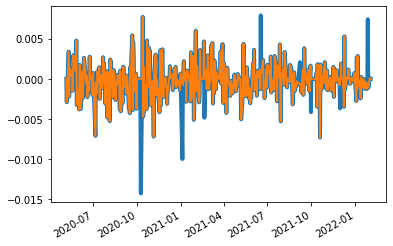

DEXJPUS


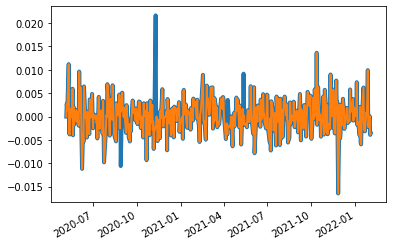

OBMMIJUMBO30YF


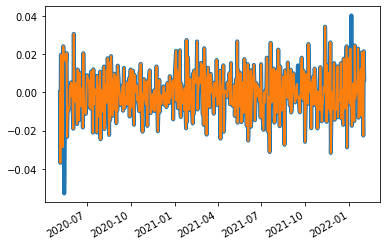

DEXUSUK


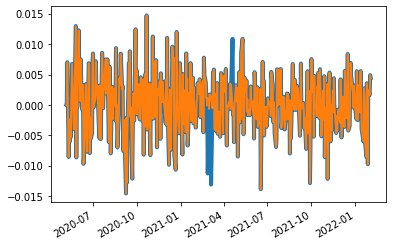

DEXKOUS


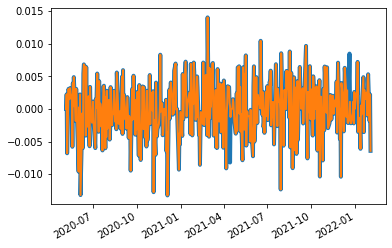

DEXCAUS


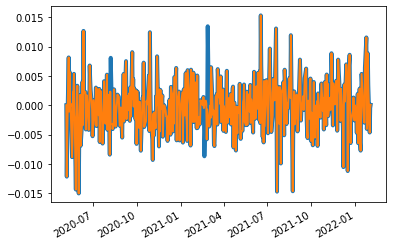

DEXMXUS


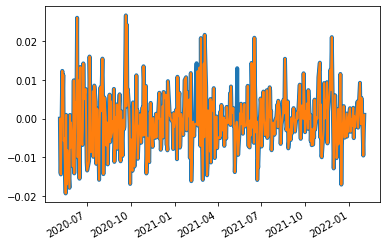

DEXVZUS


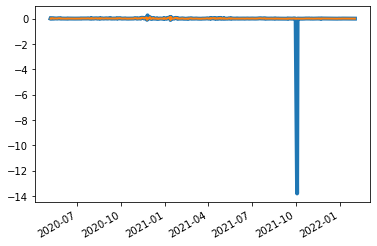

DEXBZUS


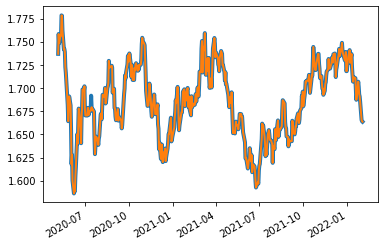

SOFRINDEX


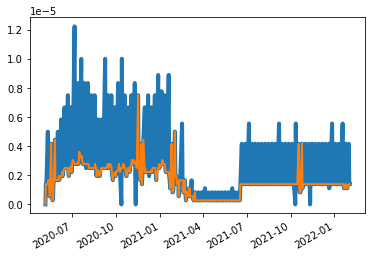

DPROPANEMBTX


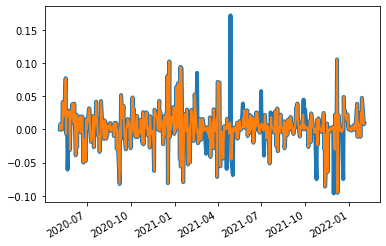

DEXMAUS


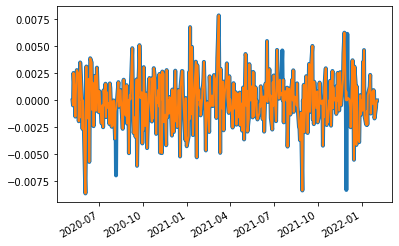

DEXTHUS


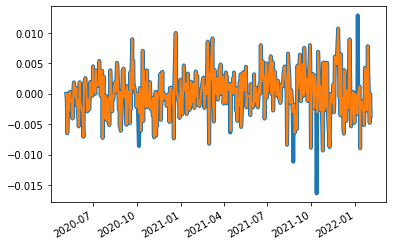

OBMMIUSDA30YF


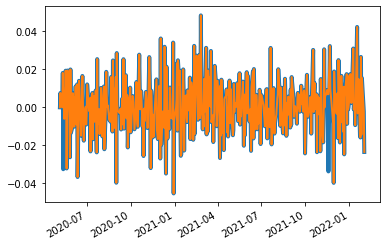

EFFRVOL


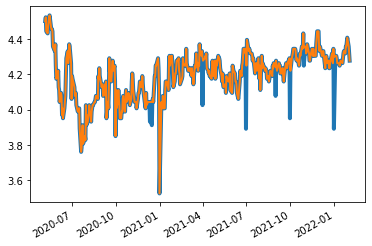

OBMMIVA30YF


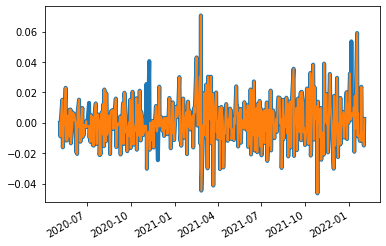

IUDZOS2


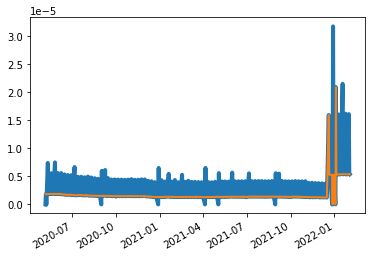

OBFRVOL


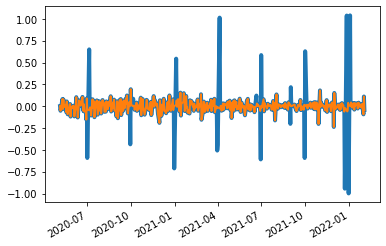

IUDZLT2


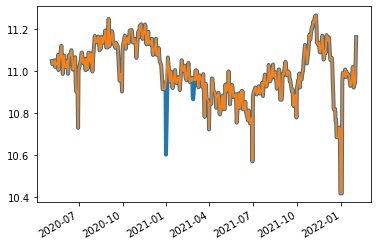

OBMMIC30YFLVLE80FB700A719


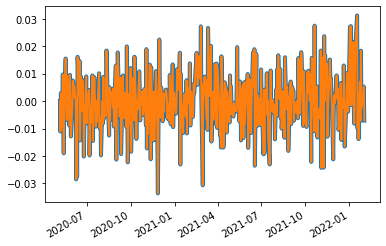

OBMMIC30YFLVLE80FLT680


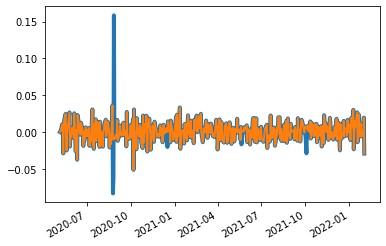

OBMMIC30YFLVGT80FLT680


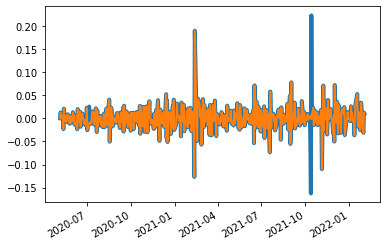

OBMMIC30YFLVLE80FB680A699


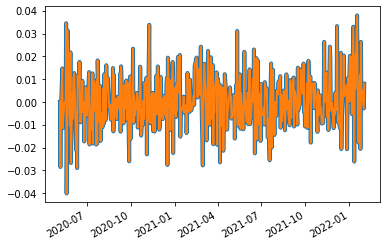

OBMMIC30YFLVGT80FB680A699


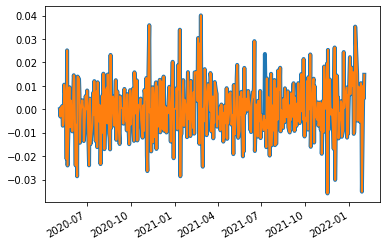

MKT59MKTAMT


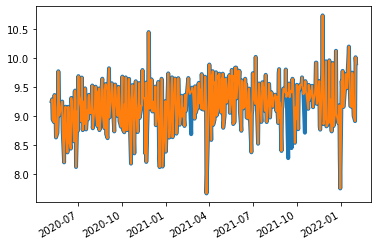

ABGT80AAAMT


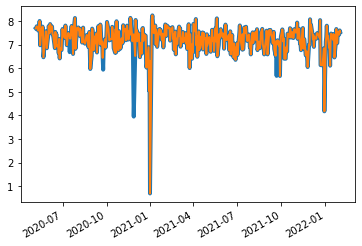

FIN14AAAMT


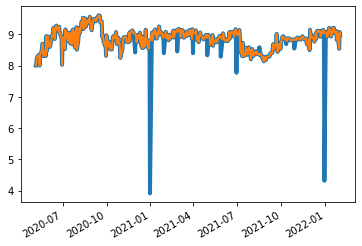

In [89]:
for e in df_copy1:
    ts = hampel(df_copy1[e], n=5, imputation=True)
    print(e)
    df_copy1[e].plot(linewidth=4)
    ts.plot(linewidth=2)
    plt.show()

## 6) Granger Causality Tests

In [90]:
# initiate a summary table that increments
summary = pd.DataFrame({'lag_selection': ['1', '2', '3']}) # instantiate dataframe
summary.set_index('lag_selection', inplace=True)
for idx, i in enumerate(df_copy1.columns):
    summary[i] = (0,0,0)

In [91]:
# fetch stock symbols data
for idxx, symbol in enumerate(tqdm(symbols)):
    print(f'\n{symbol}: {companies[idxx]}\n')
    df_temp = pd.DataFrame(pdr.DataReader(f'{symbol}', 'yahoo', '2020-05-06','2022-02-02'))['Adj Close']
    df_temp = 100 * df_temp.pct_change().dropna() # stock returns rather than flat price (stationary attributes)
    df_temp = pd.concat([df_temp, df_copy1], axis=1)
    df_temp = df_temp.dropna(subset=['Adj Close']) # drop only stock price NaNs 
    df_temp = df_temp.interpolate('pad')

    # iterate through all chosen independent variables
    for idx, i in enumerate(df_temp.columns[1:]): # [1:] is because we don't want the added stock return
        print(i)
        lag1 = False
        lag2 = False
        lag3 = False
        gc = grangercausalitytests(df_temp[['Adj Close', i]], 3, verbose=False) # lag = 3, doesnt show output
        
        # get granger causalities p-values
        for e in gc:
            a = gc[e][0].get('ssr_ftest')[1]
            b = gc[e][0].get('ssr_chi2test')[1]
            c = gc[e][0].get('lrtest')[1]
            d = gc[e][0].get('params_ftest')[1]
            p_means = (a+b+c+d)/4
            if e==1 and ((a<0.05) or (b<0.05) or (c<0.05) or (d<0.05)):
                summary[i][0] += 1
                lag1 = True
            if e==2 and ((a<0.05) or (b<0.05) or (c<0.05) or (d<0.05)):
                summary[i][1] += 1
                lag2 = True
            if e==3 and ((a<0.05) or (b<0.05) or (c<0.05) or (d<0.05)): 
                summary[i][2] += 1
                lag3 = True
        if (lag1 + lag2 + lag3) == 3:
            print(f'Granger Causality at lag 1, 2, and 3 between {companies[idxx]} \
stock price and {i} with a p-value of {round(p_means,3)}')
        elif (lag1 + lag2 + lag3) == 2:
            print(f'Granger Causality at lag 2 and 3 between {companies[idxx]} \
stock price and {i} with a p-value of {round(p_means,3)}')
        elif (lag1 + lag2 + lag3) == 1:
            print(f'Granger Causality at lag 3 between {companies[idxx]} \
stock price and {i} with a p-value of {round(p_means,3)}')
clear_output()
print('Summary table is ready')

Summary table is ready


In [92]:
# finally that beautiful summary table
summary.sort_values(by='3', axis=1, ascending=False)

ABGT80AAAMT  OBMMIUSDA30YF  DEXCAUS  DEXJPUS  DEXBZUS  IUDZOS2  \
lag_selection                                                                   
1                        1              2        2        2        6        1   
2                        0              1        4        6        3        3   
3                       12              7        7        7        5        5   

               OBMMIC30YFLVLE80FB700A719  DEXCHUS  MKT59MKTAMT  DEXKOUS  ...  \
lag_selection                                                            ...   
1                                      2        1            3        2  ...   
2                                      2        0            4        1  ...   
3                                      4        4            3        3  ...   

               OBMMIC30YFLVGT80FLT680  OBMMIC30YFLVGT80FB680A699  OBFRVOL  \
lag_selection                                                               
1                                   3                          0        2   
2                                   3                          2        1   
3                                   2                          1        1   

               SOFRINDEX  OBMMIVA30YF  EFFRVOL  FIN14AAAMT  DEXMXUS  DEXTHUS  \
lag_selection                                                                  
1                      1            2        0           2        0        0   
2                      1            2        1           2        0        0   
3                      1            1        1           1        0        0   

               DPROPANEMBTX  
lag_selection                
1                         2  
2                         0  
3                         0  

[3 rows x 27 columns]

In [93]:
summary.sort_values(by='3', axis=1, ascending=False).columns

Index(['ABGT80AAAMT', 'OBMMIUSDA30YF', 'DEXCAUS', 'DEXJPUS', 'DEXBZUS',
       'IUDZOS2', 'OBMMIC30YFLVLE80FB700A719', 'DEXCHUS', 'MKT59MKTAMT',
       'DEXKOUS', 'OBMMIC30YFLVLE80FLT680', 'IUDZLT2', 'DEXVZUS', 'DEXUSUK',
       'OBMMIJUMBO30YF', 'DEXMAUS', 'OBMMIC30YFLVLE80FB680A699',
       'OBMMIC30YFLVGT80FLT680', 'OBMMIC30YFLVGT80FB680A699', 'OBFRVOL',
       'SOFRINDEX', 'OBMMIVA30YF', 'EFFRVOL', 'FIN14AAAMT', 'DEXMXUS',
       'DEXTHUS', 'DPROPANEMBTX'],
      dtype='object')

In [100]:
# let's keep first twenty
final_df = pd.DataFrame()
for e in summary.sort_values(by='3', axis=1, ascending=False).columns[:10]:
    final_df[e] = df_copy1[e]

In [101]:
final_df

ABGT80AAAMT  OBMMIUSDA30YF   DEXCAUS   DEXJPUS   DEXBZUS  \
2020-05-06     7.693482       0.000000  0.000000  0.000000  1.736916   
2020-05-07     7.710205       0.007527 -0.012164  0.002730  1.758323   
2020-05-08     7.779049       0.001798 -0.004447  0.001315  1.748417   
2020-05-11     7.599401       0.000000  0.008162  0.011205  1.757134   
2020-05-12     7.678326       0.018099 -0.001070 -0.003441  1.756512   
...                 ...            ...       ...       ...       ...   
2022-01-27     7.068172      -0.014373  0.008852  0.009922  1.691055   
2022-01-28     7.537963       0.015430  0.003456 -0.002254  1.685343   
2022-01-31     7.425954       0.002636 -0.004637  0.000087  1.665686   
2022-02-01     7.602900      -0.002109 -0.000473 -0.003913  1.664153   
2022-02-02     7.537430      -0.023493  0.000079 -0.003579  1.663680   

             IUDZOS2  OBMMIC30YFLVLE80FB700A719   DEXCHUS  MKT59MKTAMT  \
2020-05-06  0.000000                   0.000000  0.000000     9.254931   
2020-05-07  0.000002                  -0.011085 -0.002904     9.287209   
2020-05-08  0.000000                   0.002929 -0.001314     8.938663   
2020-05-11  0.000007                  -0.009404  0.003387     8.894670   
2020-05-12  0.000002                   0.009696 -0.002200     9.361257   
...              ...                        ...       ...          ...   
2022-01-27  0.000005                  -0.002641  0.007424     9.234545   
2022-01-28  0.000005                  -0.001588 -0.001131     9.000730   
2022-01-31  0.000016                   0.001588  0.000079     8.912069   
2022-02-01  0.000005                   0.005274  0.000000    10.011265   
2022-02-02  0.000005                  -0.007127  0.000000     9.907878   

             DEXKOUS  
2020-05-06  0.000000  
2020-05-07  0.002231  
2020-05-08 -0.006792  
2020-05-11  0.003062  
2020-05-12  0.001474  
...              ...  
2022-01-27  0.004325  
2022-01-28  0.005299  
2022-01-31 -0.001871  
2022-02-01  0.002202  
2022-02-02 -0.006420  

[441 rows x 10 columns]

## 7) Variables Behaviors, Outliers

In [102]:
def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False, linewidth=1.5)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False, linewidth=1.5)
    axes[1].set_ylabel('Trend')
    res.resid.plot(ax=axes[2], legend=False, linewidth=1.5)
    axes[2].set_ylabel('Residual')

In [103]:
# convert to proper date format and fill NaNs
final_df = final_df.asfreq('d').interpolate('pad')

ABGT80AAAMT



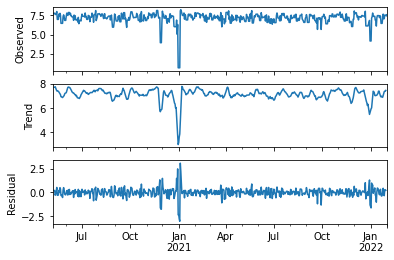

OBMMIUSDA30YF



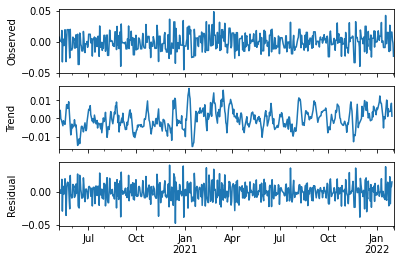

DEXCAUS



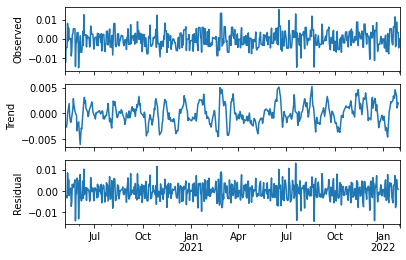

DEXJPUS



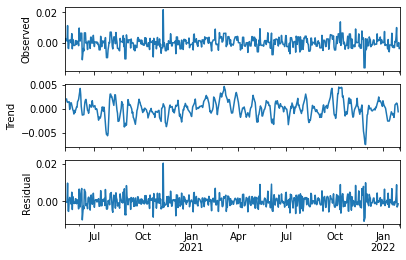

DEXBZUS



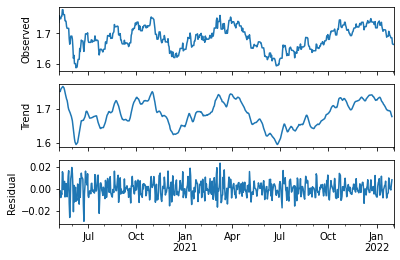

IUDZOS2



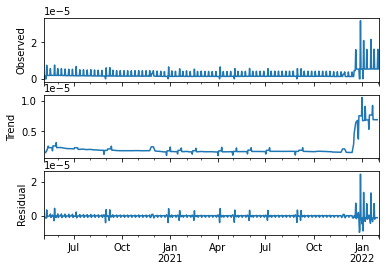

OBMMIC30YFLVLE80FB700A719



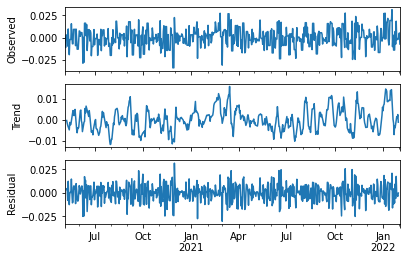

DEXCHUS



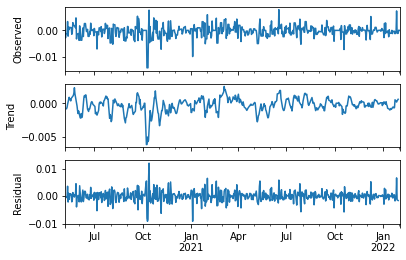

MKT59MKTAMT



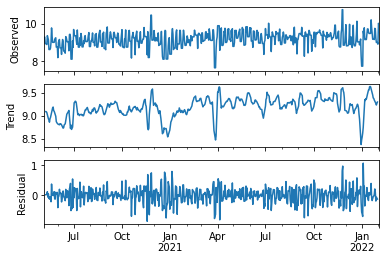

DEXKOUS



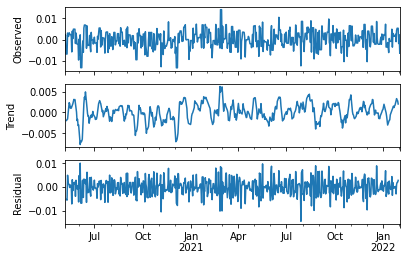

In [104]:
# get time series behaviors, seasonality, detect outliers
for e in final_df:
    print(f'{e}\n')
    res = seasonal_decompose(final_df[e])
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True)
    plotseasonal(res, axes)
    plt.show()

## 8) Check for Gaussian Distribution

In [99]:
# log-normality
for e in final_df:
    stat,p = normaltest(final_df[e])
    print("Statistics = %.3f, p=%.3f" % (stat,p))
    alpha = 0.05
    if p< alpha:
        print('The null hypothesis can be rejected: data is not Gaussian')
    else:
        print('Not enough evidence to reject the null: data looks Gaussian')

Statistics = 445.597, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 5.036, p=0.081
Not enough evidence to reject the null: data looks Gaussian
Statistics = 11.982, p=0.003
The null hypothesis can be rejected: data is not Gaussian
Statistics = 54.787, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 18.433, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 511.365, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 2.411, p=0.300
Not enough evidence to reject the null: data looks Gaussian
Statistics = 76.499, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 34.171, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 5.914, p=0.052
Not enough evidence to reject the null: data looks Gaussian
Statistics = 280.487, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 41.303, p=0.000
The null

## 9) Add technical indicators to the features

In [105]:
def compute_analytics(df, symbol):
    df['symbol'] = symbol
    df['Log Returns'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
    df['PSAR'] = 0.0
    df['EP'] = 0.0
    df['EP-PSAR'] = 0.0
    df['AccFactor'] = 0.0
    df['EP-PSAR*AccFactor'] = 0.0
    df['PSAR_signal'] = ''
    df['PSAR'][0] = df['Low'][0]
    df['EP'][0] = df['High'][0]
    df['EP-PSAR'][0] = df['EP'][0] - df['PSAR'][0]
    df['AccFactor'][0] = 0.02
    df['EP-PSAR*AccFactor'][0] = df['EP-PSAR'][0] * df['AccFactor'][0]
    df['PSAR_signal'][0] = 'Bull' if (df['EP-PSAR'][0] >= 0.0) else 'bear'
    df['upper_band'] = df['Adj Close'].rolling(10).mean() + df['Adj Close'].rolling(10).std()*2
    df['lower_band'] = df['Adj Close'].rolling(10).mean() - df['Adj Close'].rolling(10).std()*2
    df['STMAV'] = df['Adj Close'].rolling(5).mean()
    df['LTMAV'] = df['Adj Close'].rolling(10).mean()
    df['n_high'] = df['High'].rolling(10).max()
    df['n_low'] = df['Low'].rolling(10).min()
    df['%K'] = (df['Close'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
    df['%D'] = df['%K'].rolling(3).mean()
    df['delta'] = df['Close'].diff(1)
    df['delta'].dropna(inplace=True)
    df['positive'] = df['delta'].copy()
    df['negative'] = df['delta'].copy()
    df['positive'][df['positive'] < 0] = 0
    df['negative'][df['negative'] > 0] = 0
    df['average_gain'] = df['positive'].rolling(5).mean()
    df['average_lost'] = abs(df['negative'].rolling(5).mean())
    df['relative_strength'] = df['average_gain']/df['average_lost']
    df['RSI'] = 100 - (100/ (1+df['relative_strength']))
    df['EWMA'] = df['Adj Close'].ewm(span=5, adjust=False).mean()
    
    for i in range(1, len(df)):
        # PSAR calculation
        if (df['PSAR_signal'][i-1] == 'Bull') and (df['PSAR'][i-1]+df['EP-PSAR*AccFactor'][i-1] > df['Low'][i]):
            df['PSAR'][i] = df['EP'][i-1] 
        elif (df['PSAR_signal'][i-1] == 'Bear') and (df['PSAR'][i-1]+df['EP-PSAR*AccFactor'][i-1] < df['High'][i]):
            df['PSAR'][i] = df['EP'][i-1]
        else:
            df['PSAR'][i] = df['PSAR'][i-1]+df['EP-PSAR*AccFactor'][i-1]

        # signal definition
        if df['PSAR'][i] < df['High'][i]:
            df['PSAR_signal'][i] = 'Bull'
        elif df['PSAR'][i] > df['High'][i]:
            df['PSAR_signal'][i] = 'Bear'

        # EP calculation     
        if df['PSAR_signal'][i] == 'Bull' and df['High'][i] > df['EP'][i-1]:
            df['EP'][i] = df['High'][i]
        elif df['PSAR_signal'][i] == 'Bull' and df['High'][i] < df['EP'][i-1]:
            df['EP'][i] = df['EP'][i-1]
        else:
            df['EP'][i] = df['High'][i]

        if df['PSAR_signal'][i] == 'Bear' and df['Low'][i] < df['EP'][i-1]:
            df['EP'][i] = df['Low'][i]
        elif df['PSAR_signal'][i] == 'Bear' and df['Low'][i] > df['EP'][i-1]:
            df['EP'][i] = df['EP'][i-1]
        else:
            df['EP'][i] = df['High'][i]

        # EP-PSAR calculation
        df['EP-PSAR'][i] = df['EP'][i] - df['PSAR'][i]

        # accumulation factor calculation
        if df['EP'][i] != df['EP'][i-1] and df['AccFactor'][i-1]<0.19: 
            df['AccFactor'][i] = df['AccFactor'][i-1] + 0.02
        elif df['PSAR_signal'][i] != df['PSAR_signal'][i-1]:
            df['AccFactor'][i] = 0.02
        else: 
            df['AccFactor'][i] = df['AccFactor'][i-1]

        # EP-PSAR*AccFactor calculation
        df['EP-PSAR*AccFactor'][i] = df['EP-PSAR'][i] * df['AccFactor'][i]
    return df

## 10) Benchmark Comparison - Predictions on 40 stocks
* Regression
* Random Forest
* Gradient Boosting

In [107]:
# get and store complete dataframe
def fetch_api(symbols):
    df_concat = pd.DataFrame()
    for i, symbol in enumerate(symbols):
        print(i)
        a = pd.DataFrame(pdr.DataReader(f'{symbol}', 'yahoo', '2020-05-06','2022-02-02'))
        stock = compute_analytics(a, symbol)
        df_concat = pd.concat([df_concat, a])
        clear_output()
    return df_concat

In [108]:
# call the function
df = fetch_api(symbols)

  0%|          | 0/39 [00:00<?, ?it/s]

In [109]:
# set models
lr = LinearRegression()
rfc = RandomForestRegressor()
xgb = XGBRegressor()
list_models = [lr, rfc, xgb]
list_models1 = ['lr', 'rfc', 'xgb']

In [110]:
# instantiate class
class Evaluate:
    def __init__(self, algorithm):
        self.algo = algorithm
    
    def get_score(self, X_test, y_test):
        y_pred = self.algo.predict(X_test)
        R_squared = round(r2_score(y_test, y_pred), 3)
        return R_squared

In [121]:
# initiate a summary table that increments
summary = pd.DataFrame({'Model': ['Regression', 'Decision Tree', 'Gradient Descent']}) 
summary.set_index('Model', inplace=True)

for symbol in df['symbol'].unique(): 
    summary[f'{symbol}_ta'] = (0.0,0.0,0.0)
    summary[f'{symbol}_all'] = (0.0,0.0,0.0)
    df_temp = df[df['symbol']==symbol]
    print(f'\n\n{symbol}')
    
    df_reg = df_temp[['Close', 'RSI', 'PSAR', '%K', '%D', 'upper_band', 'lower_band', 'EWMA']]    
    df_reg.dropna(inplace=True)
    X = df_reg.drop('Close', axis=1)
    y = df_reg['Close']
    X_train, y_train, X_test, y_test = X[:-5], y[:-5], X[-5:], y[-5:]
    
    for idx, model in enumerate(list_models):
        model.fit(X_train, y_train)
        print(f'\n Model = {list_models1[idx]} (only macro indicators)')
        summary[f'{symbol}_ta'][idx] = Evaluate(model).get_score(X_test, y_test)
    
    df_reg = pd.concat([df_reg, final_df], axis=1)
    df_reg = df_reg.dropna(subset=['Close', 'RSI', '%K', '%D', 'upper_band', 'lower_band', 'EWMA'])
    df_reg.interpolate('pad', inplace=True)
    X = df_reg.drop('Close', axis=1)
    y = df_reg['Close']
    X_train, y_train, X_test, y_test = X[:-5], y[:-5], X[-5:], y[-5:]
    
    for idx, model in enumerate(list_models):
        model.fit(X_train, y_train)
        print(f'\nModel = {list_models1[idx]} (technical and macro indicators)')
        summary[f'{symbol}_all'][idx] = Evaluate(model).get_score(X_test, y_test)



ADBE

 Model = lr (only macro indicators)

 Model = rfc (only macro indicators)

 Model = xgb (only macro indicators)

Model = lr (technical and macro indicators)

Model = rfc (technical and macro indicators)

Model = xgb (technical and macro indicators)


GOOGL

 Model = lr (only macro indicators)

 Model = rfc (only macro indicators)

 Model = xgb (only macro indicators)

Model = lr (technical and macro indicators)

Model = rfc (technical and macro indicators)

Model = xgb (technical and macro indicators)


AMZN

 Model = lr (only macro indicators)

 Model = rfc (only macro indicators)

 Model = xgb (only macro indicators)

Model = lr (technical and macro indicators)

Model = rfc (technical and macro indicators)

Model = xgb (technical and macro indicators)


AMD

 Model = lr (only macro indicators)

 Model = rfc (only macro indicators)

 Model = xgb (only macro indicators)

Model = lr (technical and macro indicators)

Model = rfc (technical and macro indicators)

Model = xgb (tech

In [122]:
# get the summary table 
summary.style.background_gradient(axis=1, vmin=0, vmax=1)

## 11) Benchmark Comparison - Predictions on 40 stocks but PCA

In [136]:
# initiate a summary table that increments
summary1 = pd.DataFrame({'Model': ['Regression', 'Decision Tree', 'Gradient Descent']}) 
summary1.set_index('Model', inplace=True)
summary2 = pd.DataFrame({'Model': ['Regression', 'Decision Tree', 'Gradient Descent']}) 
summary2.set_index('Model', inplace=True)
summary3 = pd.DataFrame({'Model': ['Regression', 'Decision Tree', 'Gradient Descent']}) 
summary3.set_index('Model', inplace=True)

for symbol in df['symbol'].unique(): 
    summary1[f'{symbol}'] = (0.0,0.0,0.0)
    summary2[f'{symbol}'] = (0.0,0.0,0.0)
    summary3[f'{symbol}'] = (0.0,0.0,0.0)
    
    df_temp = df[df['symbol']==symbol]
    print(f'\n\n{symbol}')
    df_reg = df_temp[['Close', 'RSI', 'PSAR', '%K', '%D', 'upper_band', 'lower_band', 'EWMA']]    
    df_reg.dropna(inplace=True)    
    df_reg = pd.concat([df_reg, final_df], axis=1)
    df_reg = df_reg.dropna(subset=['Close', 'RSI', '%K', '%D', 'upper_band', 'lower_band', 'EWMA'])
    df_reg.interpolate('pad', inplace=True)
    X = df_reg.drop('Close', axis=1)
    y = df_reg['Close']
    
    # normalize data (μ = 0 and σ = 1)
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    pca = PCA(n_components = 2) 
    X_new = pca.fit_transform(X)
    X_new = pd.DataFrame(X_new)
    print('\nVariance table: ',pca.explained_variance_ratio_)
    X_train, y_train, X_test, y_test = X_new[:-5], y[:-5], X_new[-5:], y[-5:]
    
    for idx, model in enumerate(list_models):
        model.fit(X_train, y_train)
        print(f'\nModel = {list_models1[idx]} (technical and macro indicators)')
        summary1[f'{symbol}'][idx] = Evaluate(model).get_score(X_test, y_test)
        
    # second wave with 3 PCA resultant variables    
    pca = PCA(n_components = 3) 
    X_new = pca.fit_transform(X)
    X_new = pd.DataFrame(X_new)
    print('\nVariance table: ',pca.explained_variance_ratio_)
    X_train, y_train, X_test, y_test = X_new[:-5], y[:-5], X_new[-5:], y[-5:]
    
    for idx, model in enumerate(list_models):
        model.fit(X_train, y_train)
        print(f'\nModel = {list_models1[idx]} (technical and macro indicators)')
        summary2[f'{symbol}'][idx] = Evaluate(model).get_score(X_test, y_test)
        
    # third wave with n PCA resultant variables (95% variance explained)   
    pca = PCA(n_components = 0.95) 
    X_new = pca.fit_transform(X)
    X_new = pd.DataFrame(X_new)
    print('\nVariance table: ',pca.explained_variance_ratio_)
    X_train, y_train, X_test, y_test = X_new[:-5], y[:-5], X_new[-5:], y[-5:]
    
    for idx, model in enumerate(list_models):
        model.fit(X_train, y_train)
        print(f'\nModel = {list_models1[idx]} (technical and macro indicators)')
        summary3[f'{symbol}'][idx] = Evaluate(model).get_score(X_test, y_test)



ADBE

Variance table:  [0.23903017 0.16956833]

Model = lr (technical and macro indicators)

Model = rfc (technical and macro indicators)

Model = xgb (technical and macro indicators)

Variance table:  [0.23903017 0.16956833 0.1053035 ]

Model = lr (technical and macro indicators)

Model = rfc (technical and macro indicators)

Model = xgb (technical and macro indicators)

Variance table:  [0.23903017 0.16956833 0.1053035  0.09070679 0.06885207 0.05962159
 0.05452714 0.04816315 0.04409749 0.03852154 0.03207126]

Model = lr (technical and macro indicators)

Model = rfc (technical and macro indicators)

Model = xgb (technical and macro indicators)


GOOGL

Variance table:  [0.24610875 0.16159291]

Model = lr (technical and macro indicators)

Model = rfc (technical and macro indicators)

Model = xgb (technical and macro indicators)

Variance table:  [0.24610875 0.16159291 0.10032669]

Model = lr (technical and macro indicators)

Model = rfc (technical and macro indicators)

Model = xgb (

In [137]:
# get the summary table 
summary1.style.background_gradient(axis=1, vmin=0, vmax=1)

In [138]:
# get the summary table 
summary2.style.background_gradient(axis=1, vmin=0, vmax=1)

In [139]:
# get the summary table 
summary3.style.background_gradient(axis=1, vmin=0, vmax=1)

## 11) Random Search To Optimize XGBoost Parameters

* iterates through all parameters to find the best combination

In [36]:
for symbol in df['symbol'].unique()[:6]:
    df_temp = df[df['symbol']==symbol]
    print(f'\n\n{symbol}')

    df_reg = df_temp[['Close', 'RSI', 'PSAR', '%K', '%D', 'upper_band', 'lower_band', 'EWMA']]    
    df_reg.dropna(inplace=True)
    X = df_reg.drop('Close', axis=1)
    y = df_reg['Close']
    X_train, y_train, X_test, y_test = X[:-5], y[:-5], X[-5:], y[-5:]
    XGBR = XGBRegressor()

    params = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
    }

    n_iter_search = 15 #should be 100
    random_search = RandomizedSearchCV(XGBR, param_distributions=params,
                                       n_iter=n_iter_search, cv=5, scoring='r2', verbose=0)

    random_search.fit(X_train, y_train)
    best_regressor = random_search.best_estimator_

    y_pred = best_regressor.predict(X_test)

    # Calculate MAE
    rmse_pred = mean_absolute_error(y_test, y_pred)

    # Get predictions
    y_pred_test = best_regressor.predict(X_test)

    print(best_regressor)



ADBE
[23:44:59] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:45:00] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bi

KeyboardInterrupt: 

In [ ]:
# get another summary table with new XGB
xgb = XGBRegressor(base_score=0.5, booster='gbtree', boosting_type='goss',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6444444444444444, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', is_unbalance=False,
             learning_rate=0.16923864279729905, max_delta_step=0, max_depth=6,
             min_child_samples=385, min_child_weight=1,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_leaves=75, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.0, reg_lambda=0.2040816326530612,
             scale_pos_weight=1, subsample=0.797979797979798,
             subsample_for_bin=40000)
list_models = [lr, rfc, xgb]

## 12) Predictions plots

ADBE
R2 for the below: 0.989 lr
R2 for the below: 0.843 rfc
[05:01:17] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.712 xgb


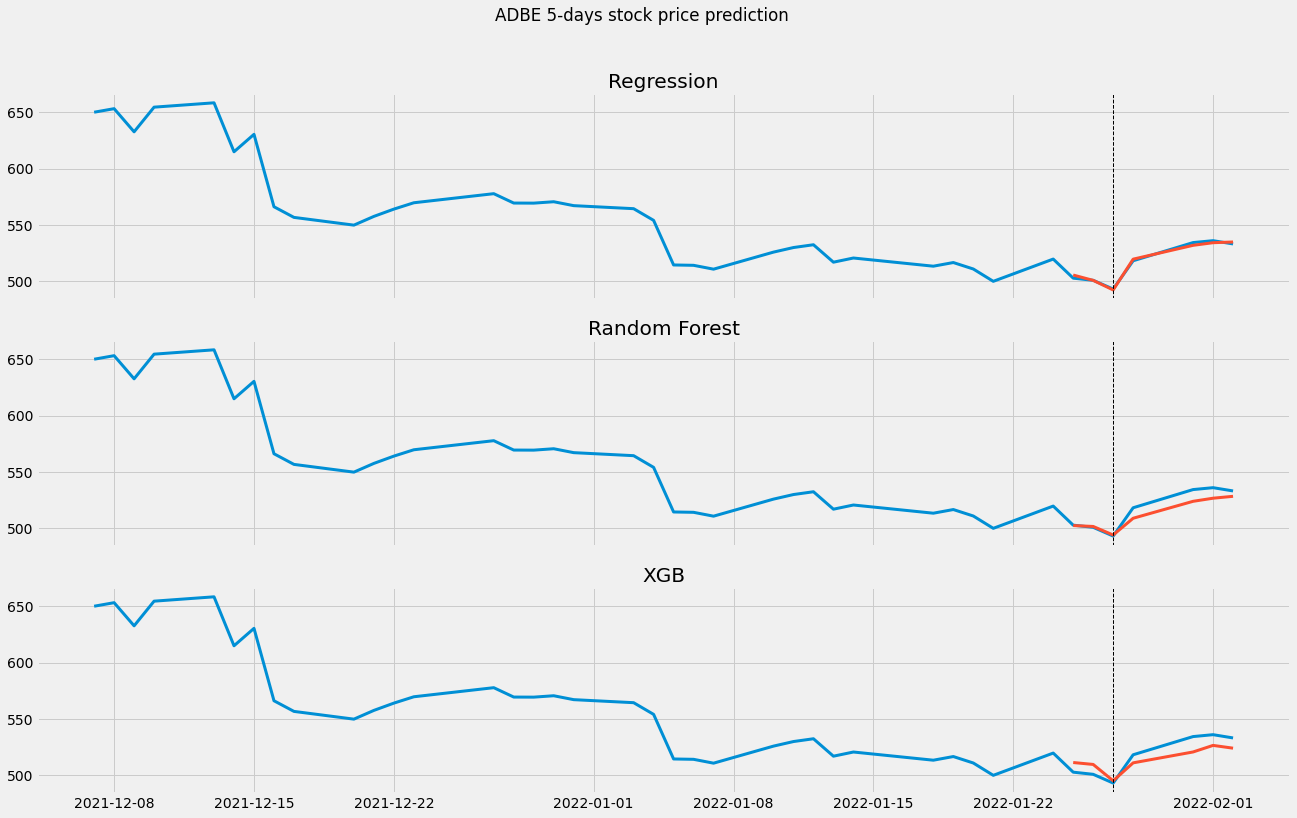

GOOGL
R2 for the below: 0.873 lr
R2 for the below: 0.5 rfc
[05:01:18] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.466 xgb


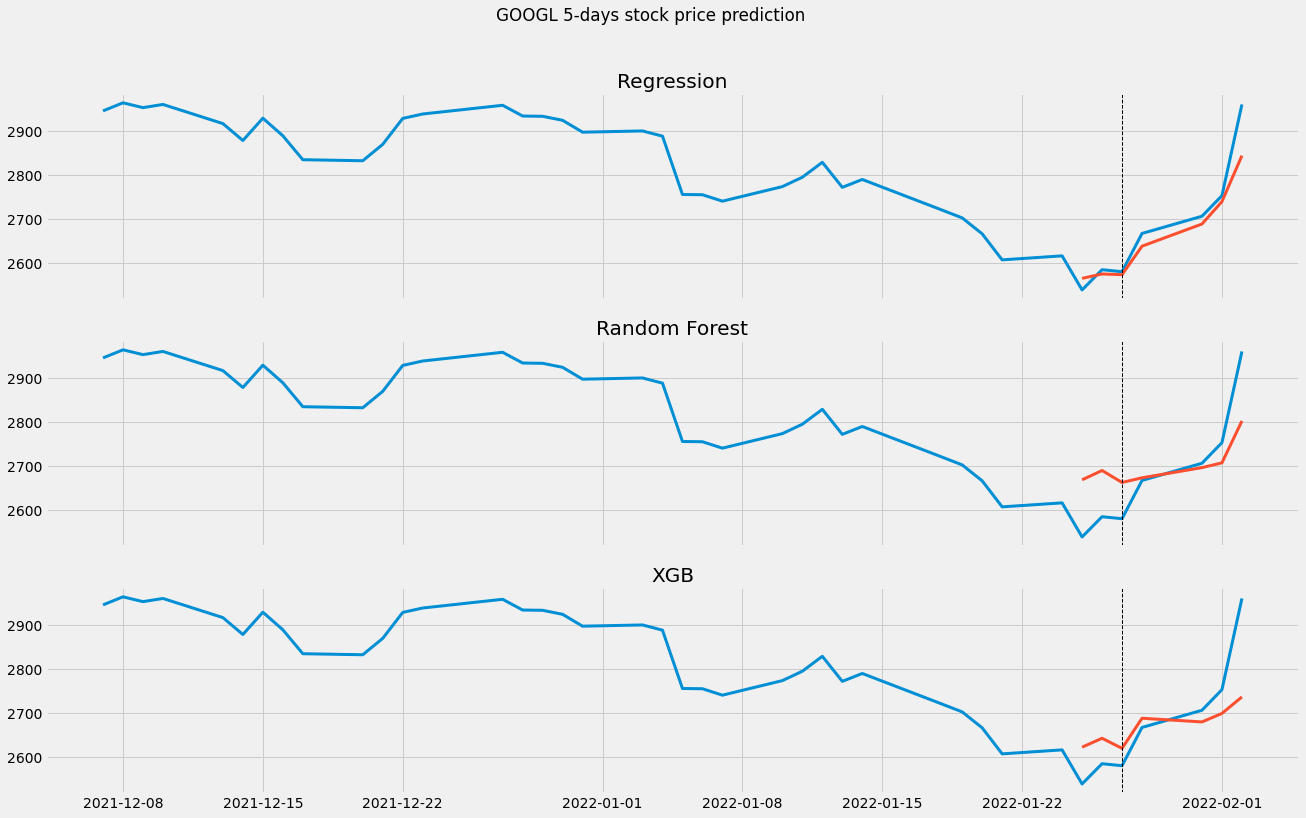

GOOG
R2 for the below: 0.882 lr
R2 for the below: 0.574 rfc
[05:01:18] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: -0.068 xgb


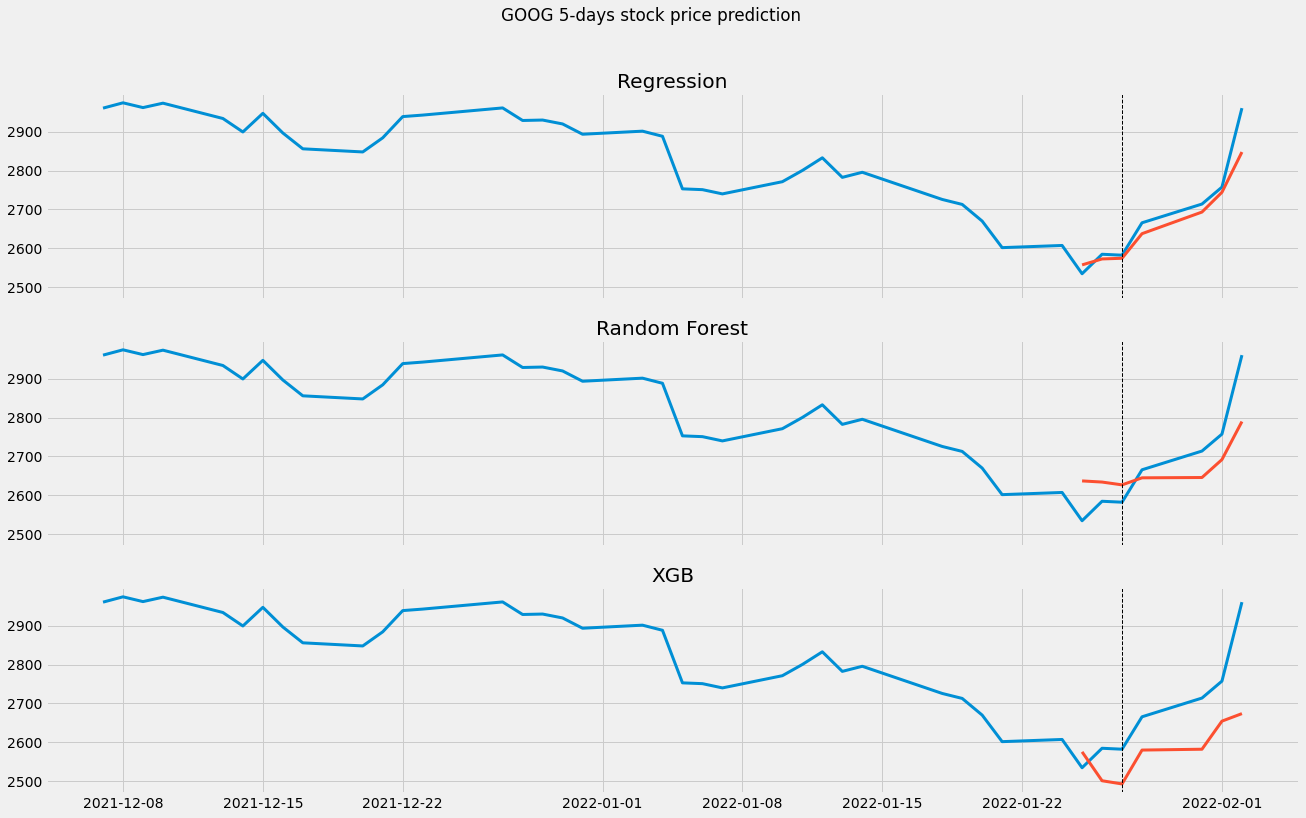

AMZN
R2 for the below: 0.896 lr
R2 for the below: -0.089 rfc
[05:01:19] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: -0.411 xgb


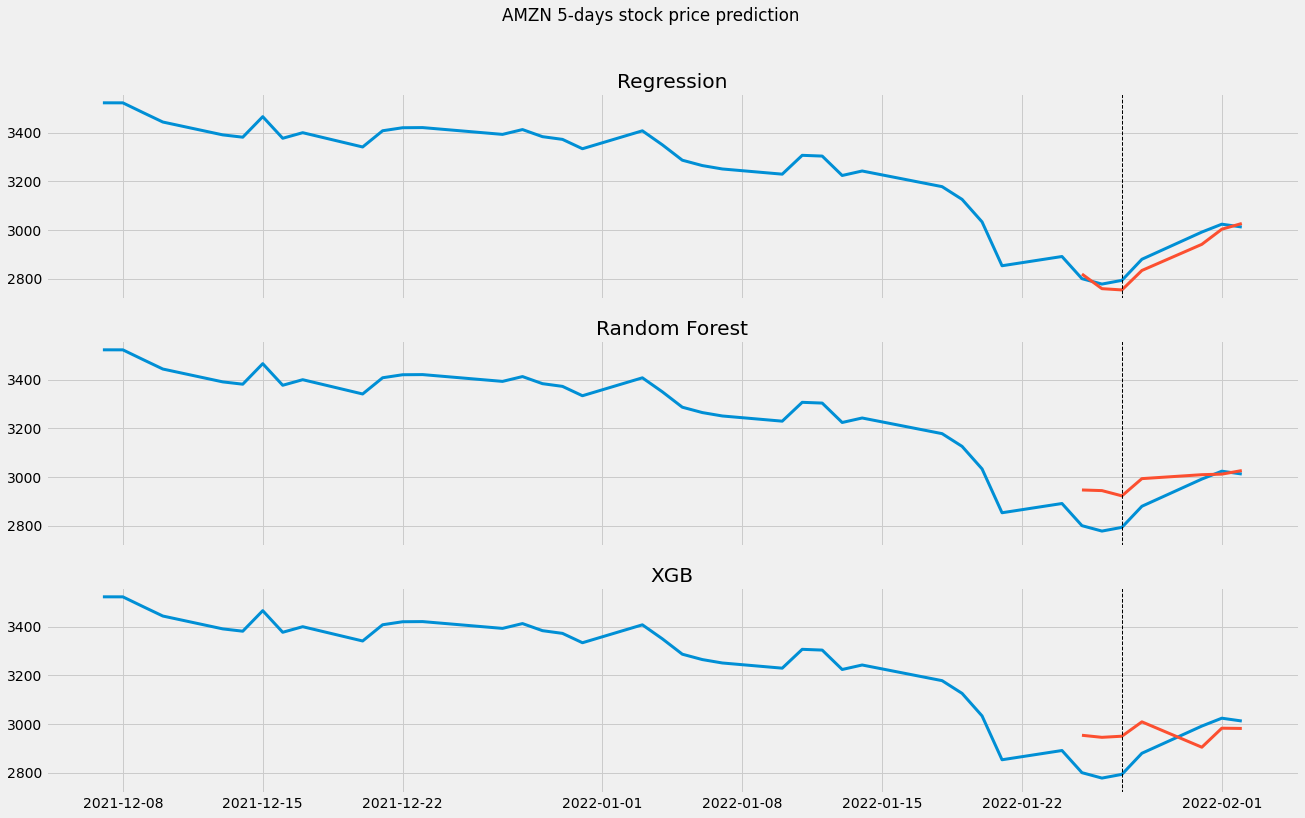

AMD
R2 for the below: 0.855 lr
R2 for the below: -0.146 rfc
[05:01:20] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: -0.272 xgb


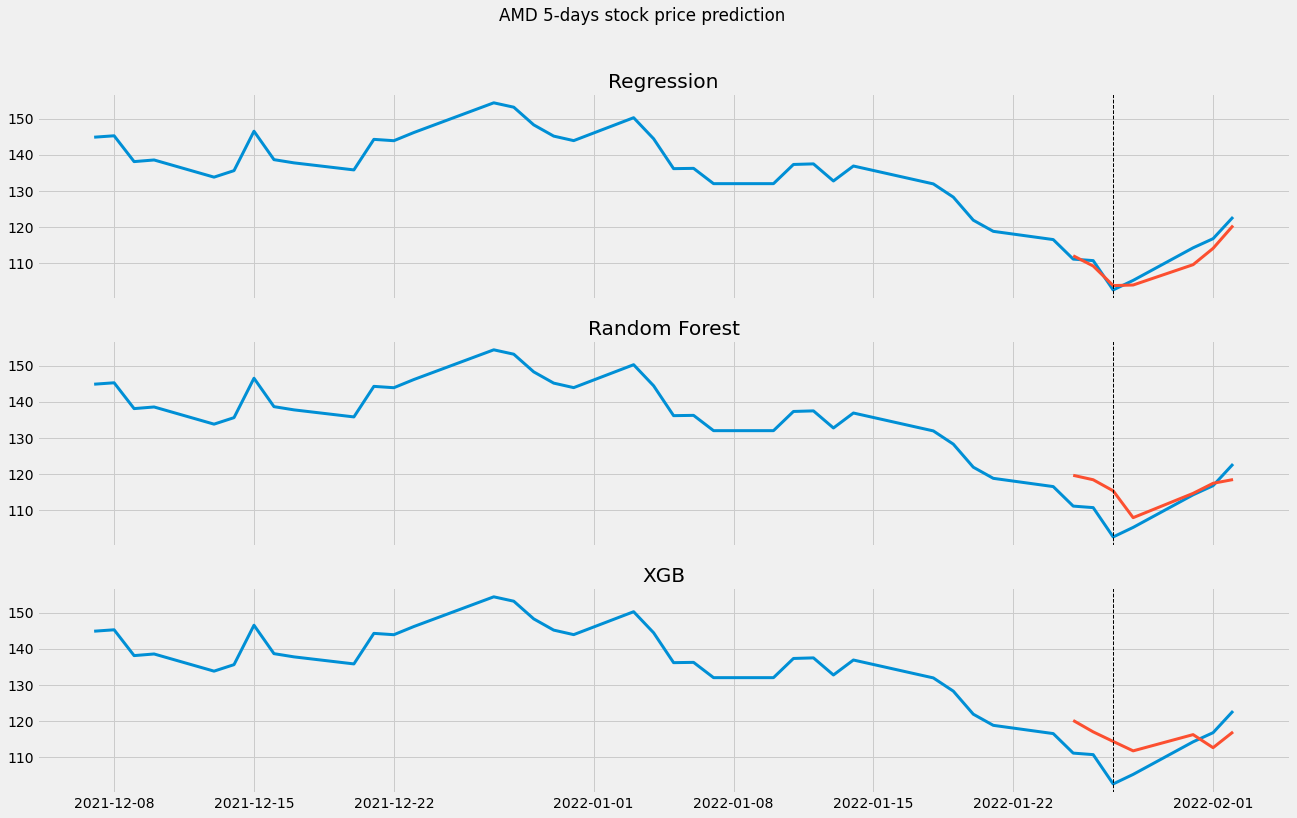

AEP
R2 for the below: 0.798 lr
R2 for the below: -0.916 rfc
[05:01:20] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.064 xgb


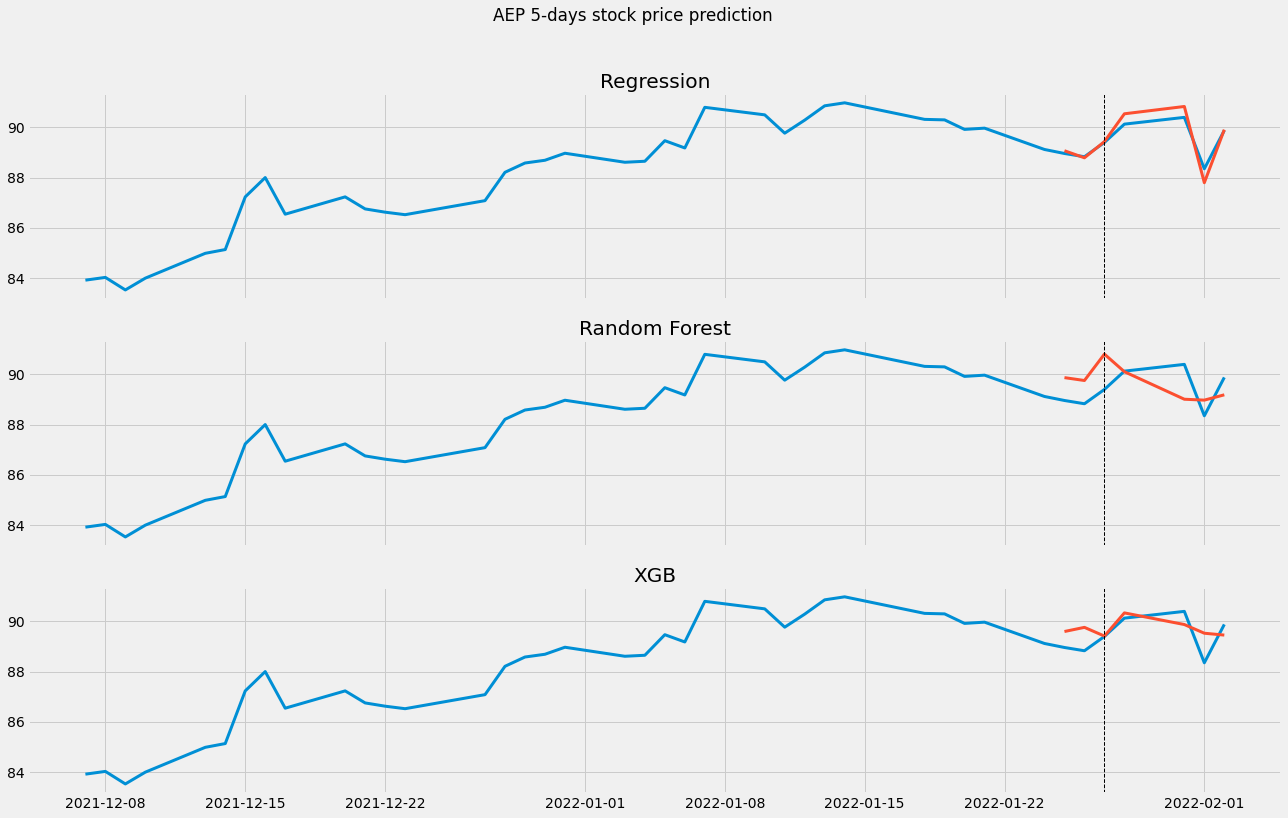

AMGN
R2 for the below: -1.296 lr
R2 for the below: 0.252 rfc
[05:01:21] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.403 xgb


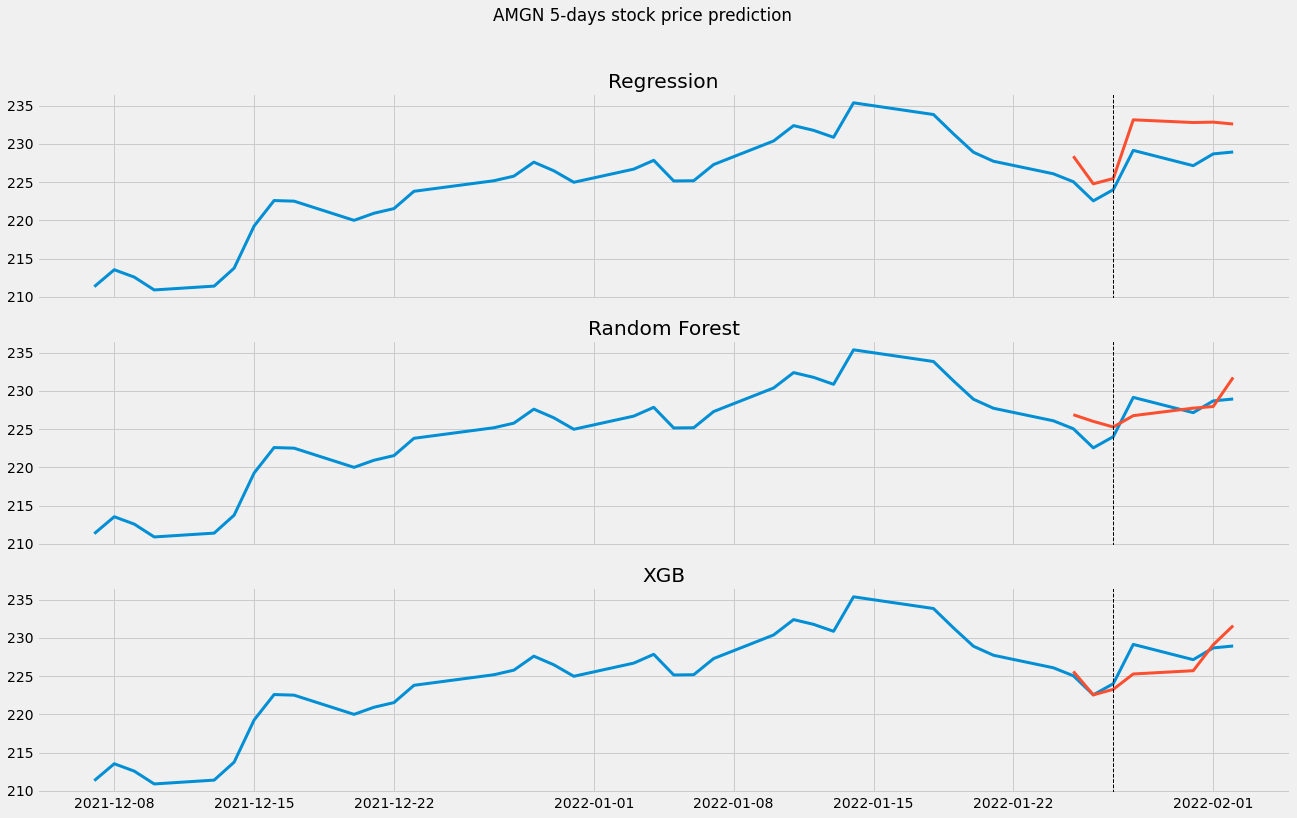

ADI
R2 for the below: 0.947 lr
R2 for the below: 0.604 rfc
[05:01:21] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.718 xgb


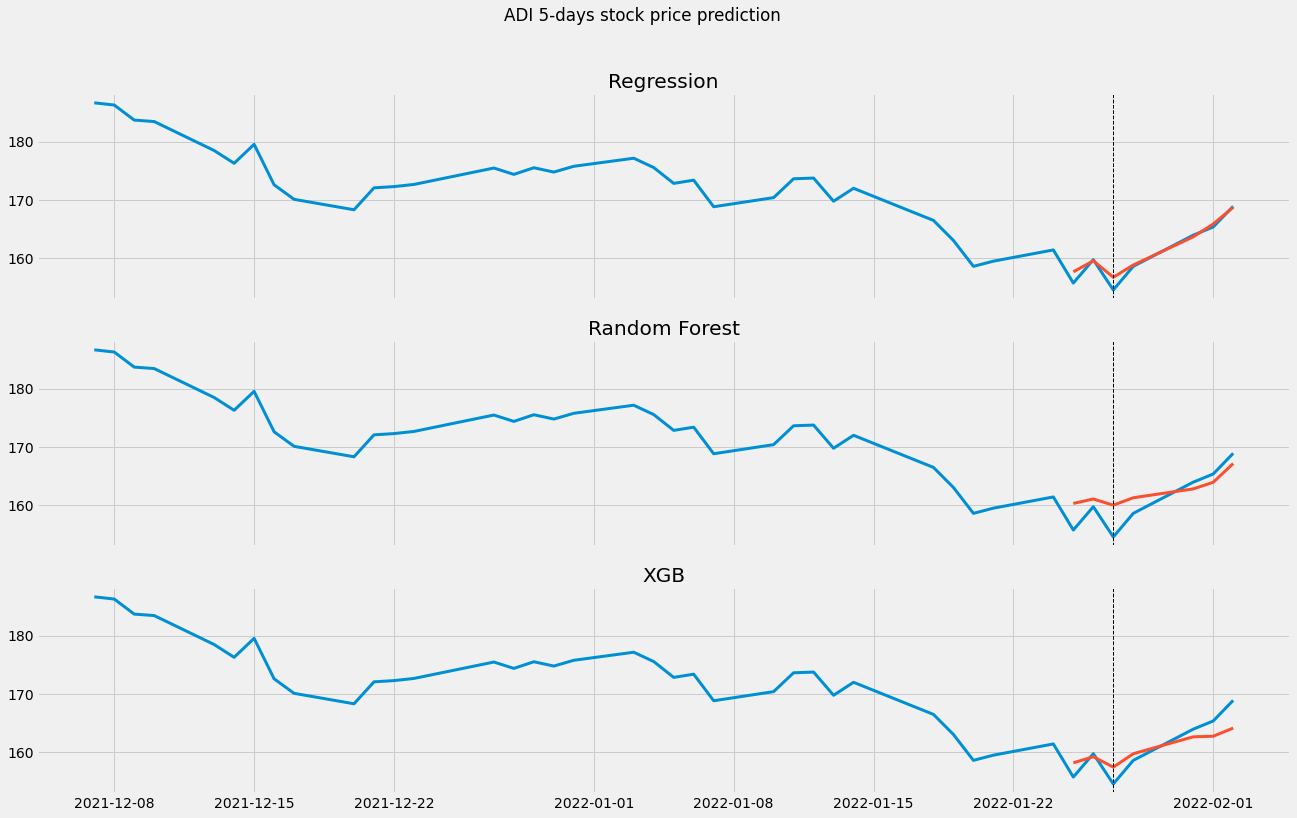

ANSS
R2 for the below: 0.969 lr
R2 for the below: 0.898 rfc
[05:01:22] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.818 xgb


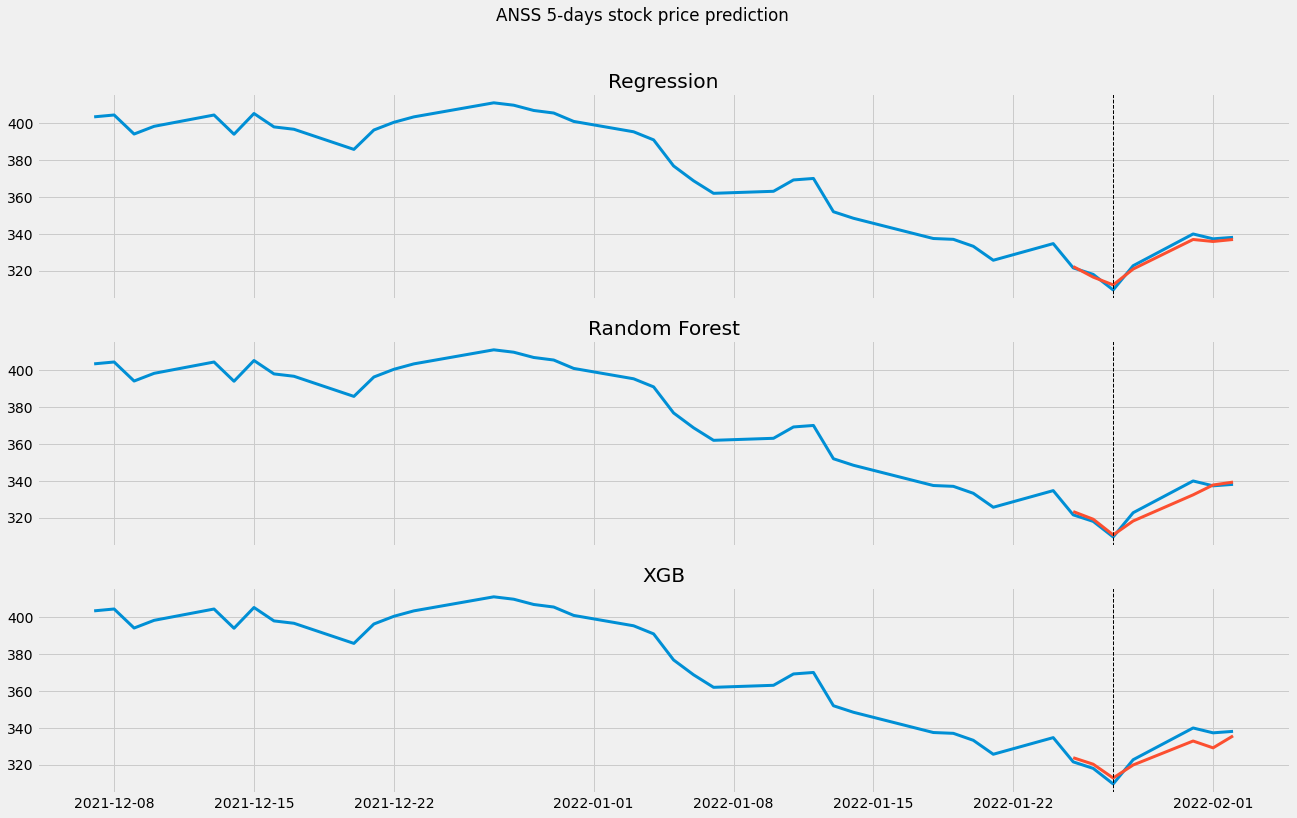

AAPL
R2 for the below: 0.962 lr
R2 for the below: 0.553 rfc
[05:01:23] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.867 xgb


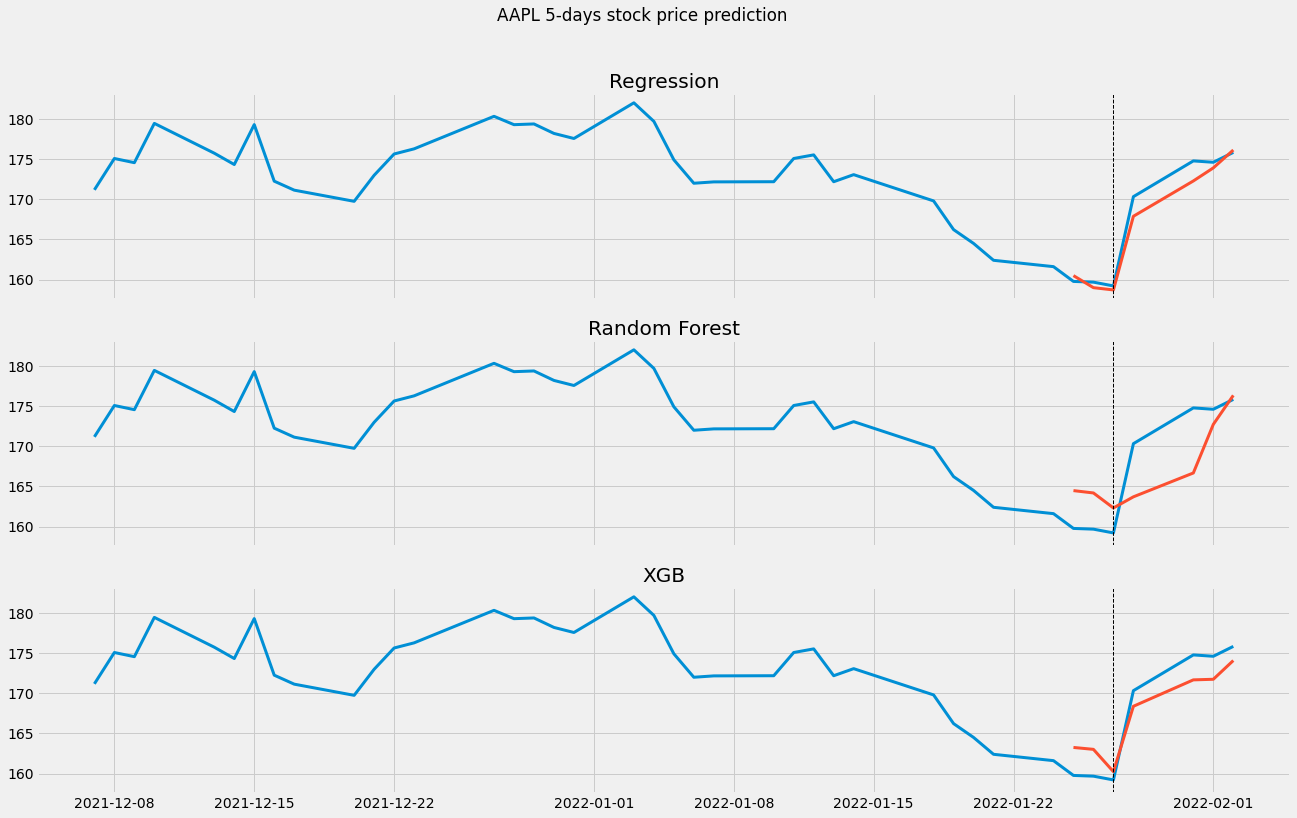

AMAT
R2 for the below: 0.856 lr
R2 for the below: 0.527 rfc
[05:01:23] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.789 xgb


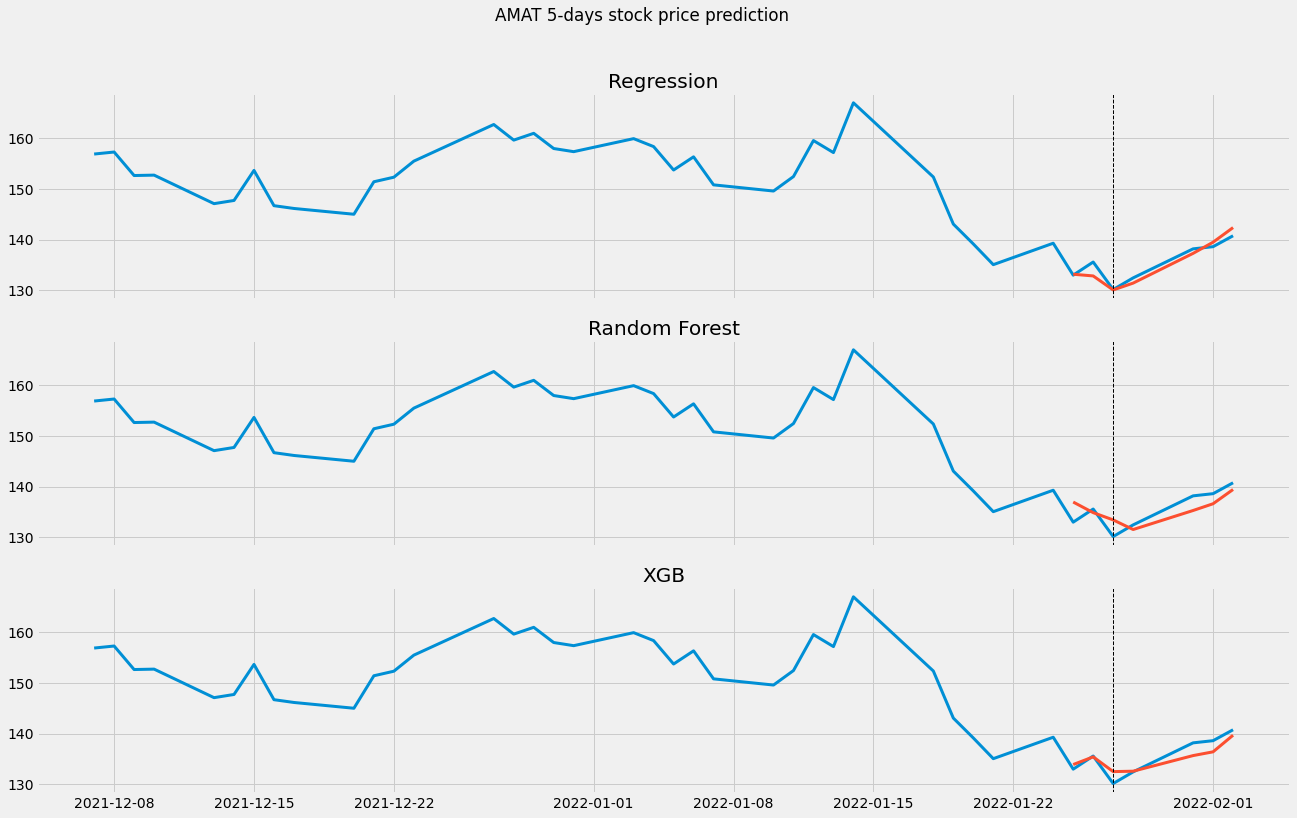

ASML
R2 for the below: 0.841 lr
R2 for the below: -0.121 rfc
[05:01:24] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.261 xgb


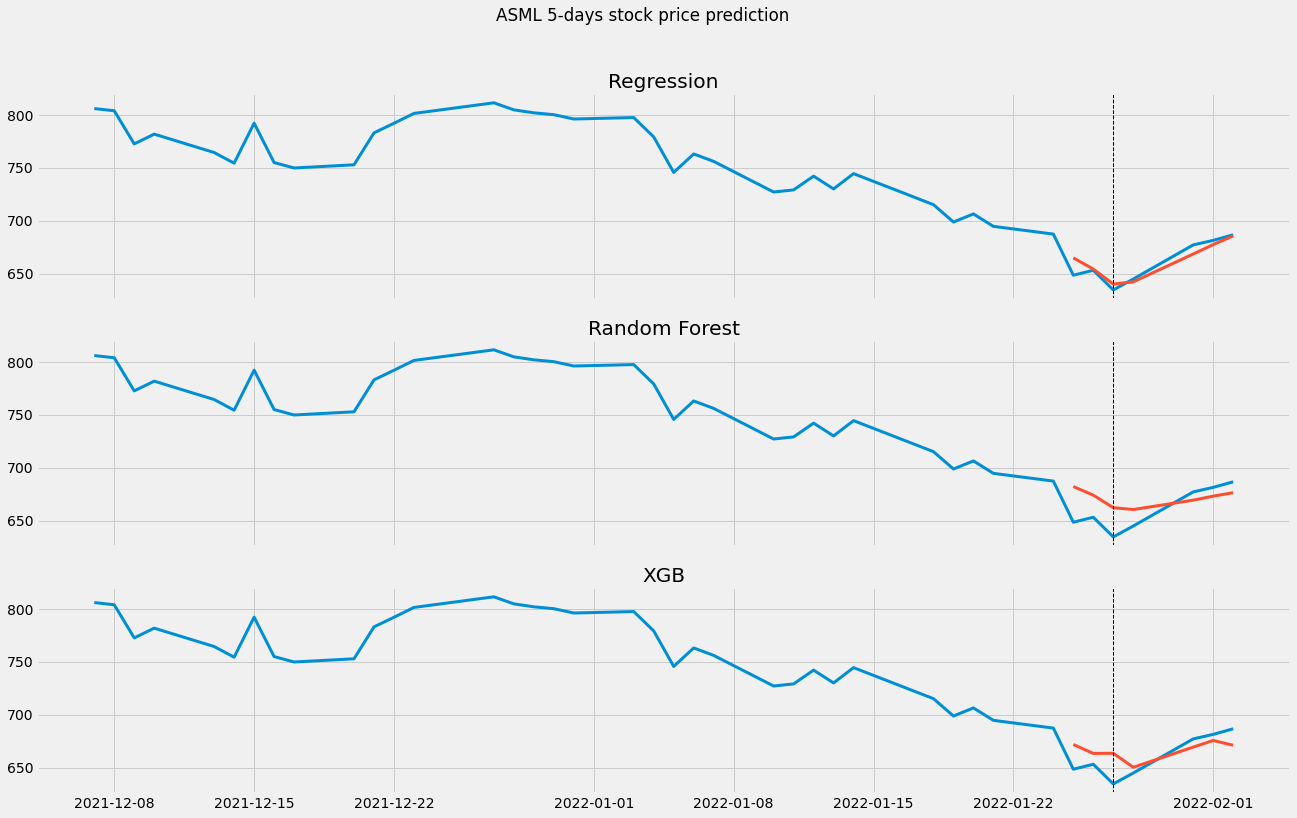

TEAM
R2 for the below: 0.949 lr
R2 for the below: 0.723 rfc
[05:01:25] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.834 xgb


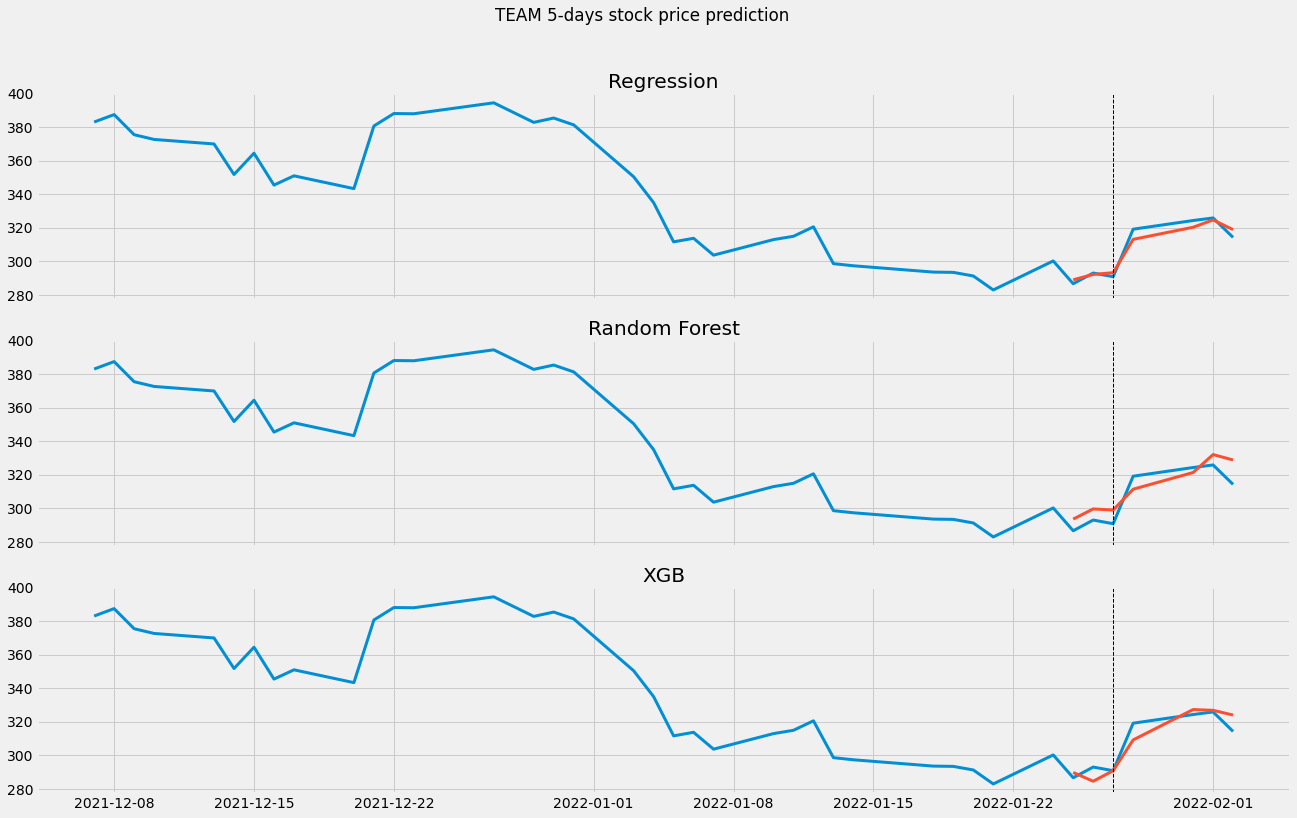

ADSK
R2 for the below: 0.946 lr
R2 for the below: 0.788 rfc
[05:01:25] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.798 xgb


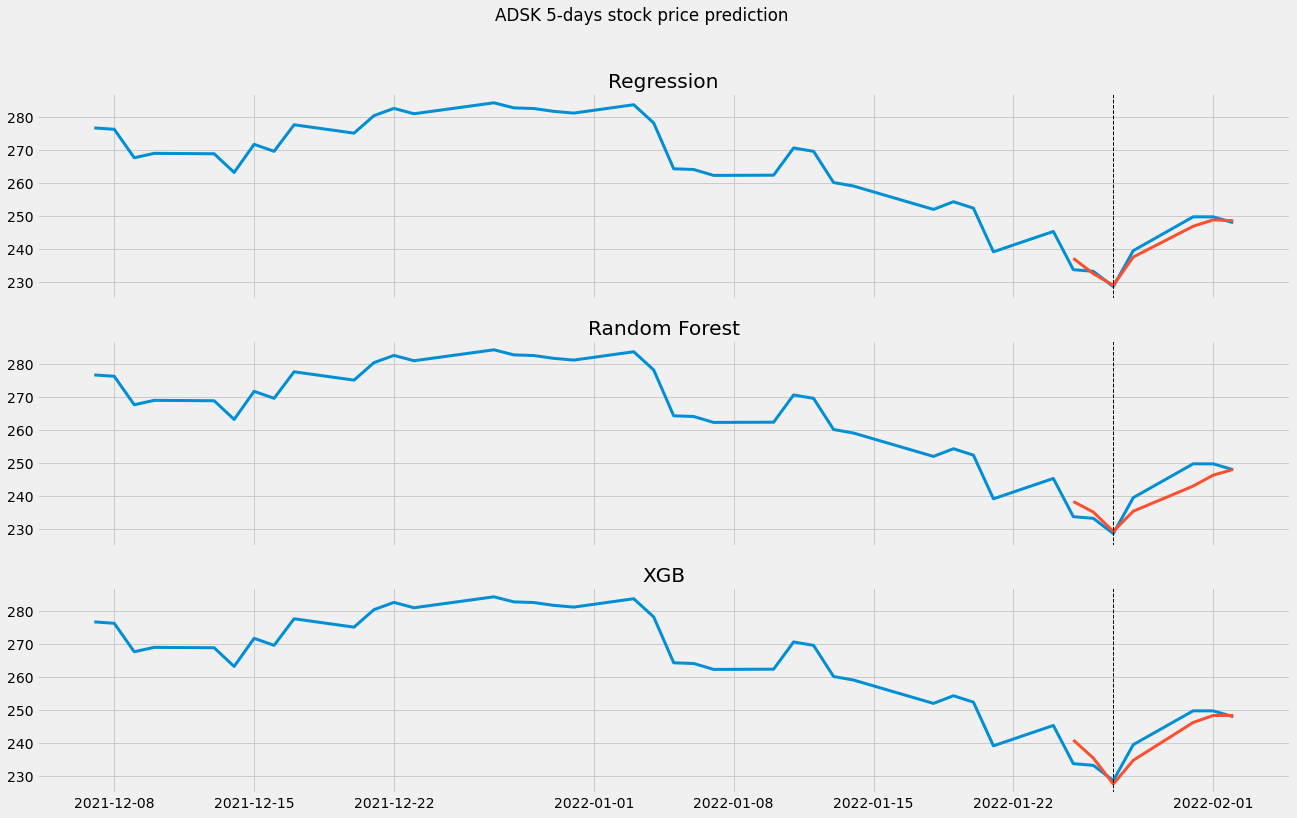

ADP
R2 for the below: 0.633 lr
R2 for the below: -1.123 rfc
[05:01:26] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.022 xgb


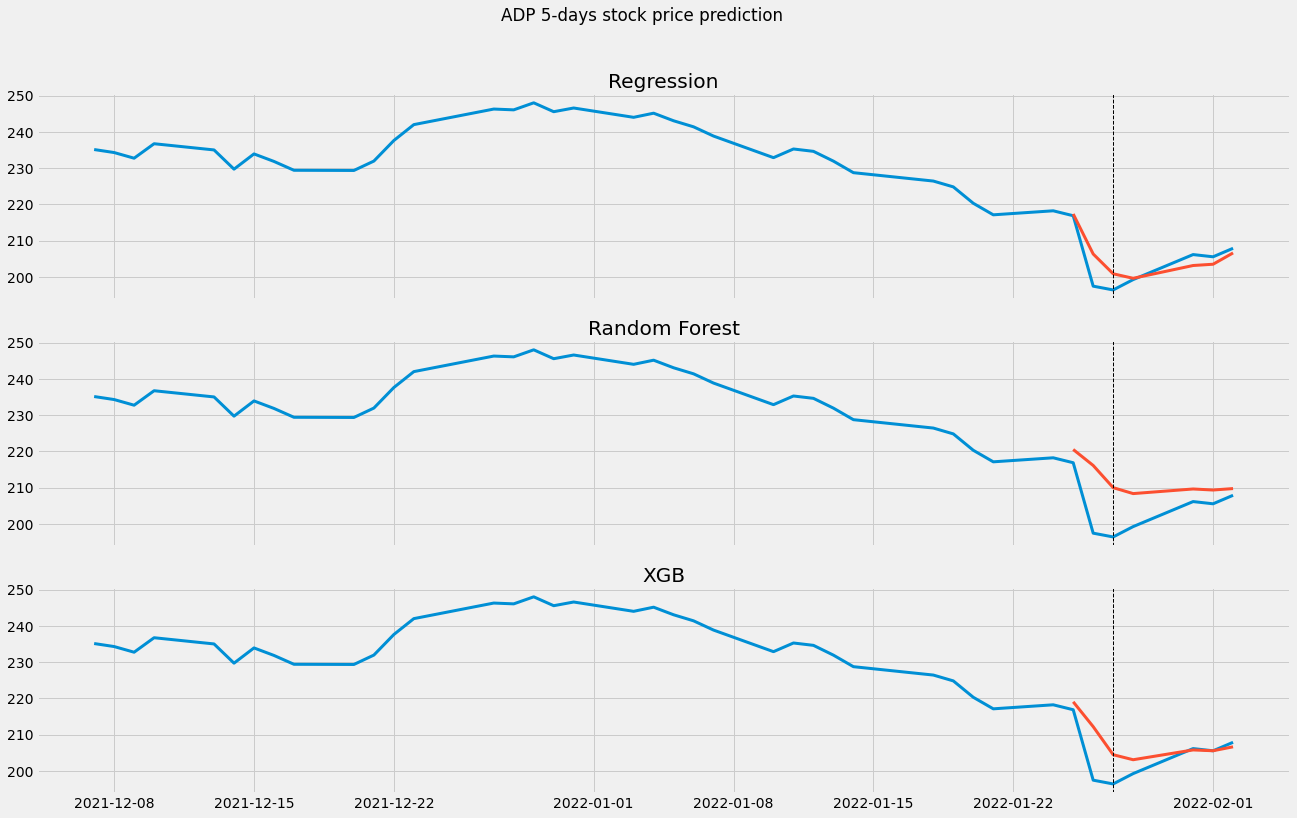

BIDU
R2 for the below: 0.984 lr
R2 for the below: 0.706 rfc
[05:01:26] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: 0.851 xgb


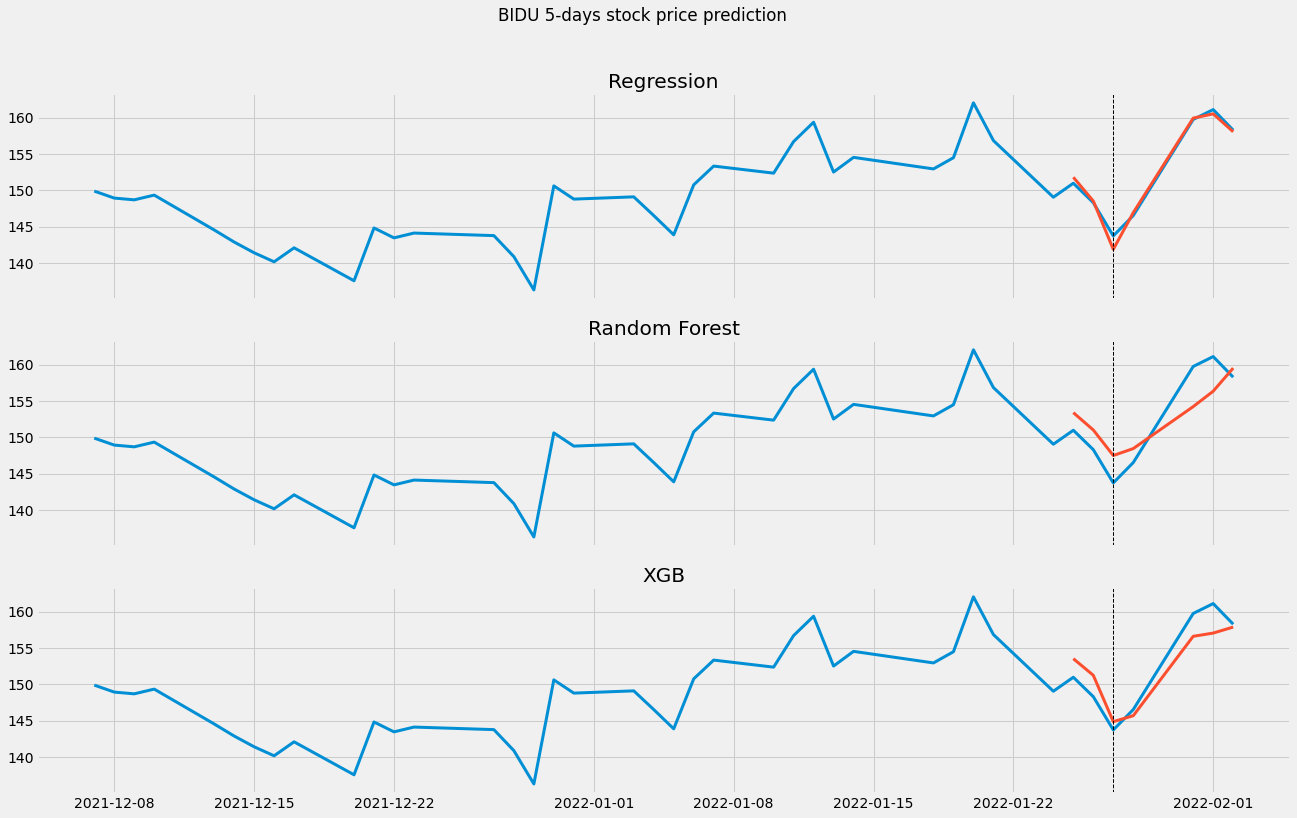

BIIB
R2 for the below: 0.376 lr
R2 for the below: -1.665 rfc
[05:01:27] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 for the below: -3.031 xgb


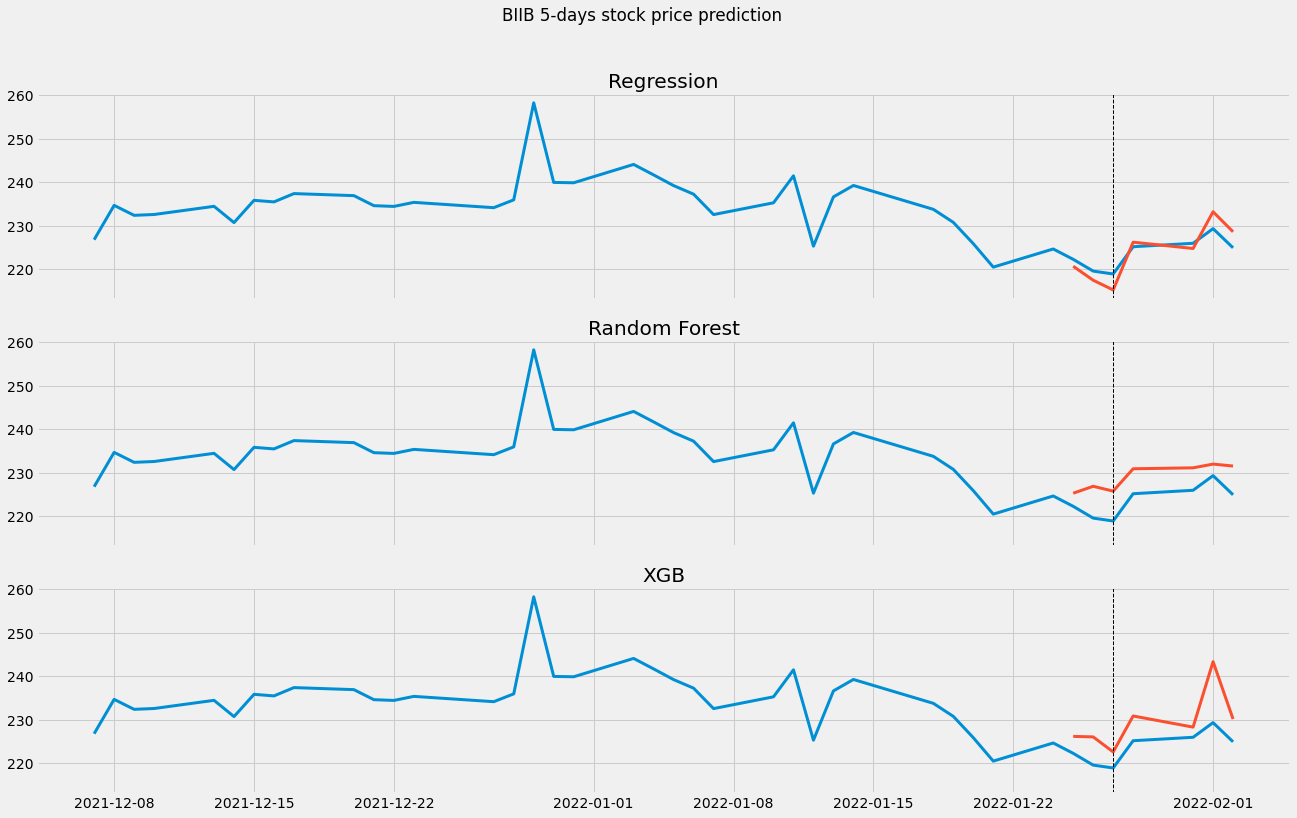

BKNG
R2 for the below: 0.947 lr


KeyboardInterrupt: 

In [150]:
pred_days = 5 # number of days to be predicted
for symbol in df['symbol'].unique():
    df_temp = df[df['symbol']==symbol]
    df_reg = df_temp[['Close', 'RSI', 'PSAR', '%K', '%D', 'upper_band', 'lower_band', 'EWMA']]    
    df_reg.dropna(inplace=True)
    df_reg = pd.concat([df_reg, final_df], axis=1)
    df_reg = df_reg.dropna(subset=['Close', 'RSI', '%K', '%D', 'upper_band', 'lower_band', 'EWMA'])
    df_reg.interpolate('pad', inplace=True)
    X = df_reg.drop('Close', axis=1)
    y = df_reg['Close']
    X_train, y_train, X_test, y_test = X[:-pred_days], y[:-pred_days], X[-pred_days:], y[-pred_days:]
    print(symbol)
    
    df_pred = pd.DataFrame()
    for idx, model in enumerate(list_models):    
        model.fit(X_train, y_train)
        #print(lr.coef_)
        y_pred = model.predict(X_test)
        y_preddf = pd.DataFrame(y_pred, columns=['y_pred'])
        y_preddf.set_index(y_test.index, inplace=True)
        df_pred[idx] = y_preddf
        print('R2 for the below:', Evaluate(model).get_score(X_test, y_test), list_models1[idx])
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
    fig.suptitle(f'{symbol} 5-days stock price prediction')
    ax1.plot(y[390:], linewidth=3)
    ax1.plot(df_pred[0], linewidth=3)
    ax1.set_title('Regression')
    ax1.axvline(19019, color = 'black', linewidth = 1, linestyle = '--')
    ax2.plot(y[390:], linewidth=3)
    ax2.plot(df_pred[1], linewidth=3)
    ax2.set_title('Random Forest')
    ax2.axvline(19019, color = 'black', linewidth = 1, linestyle = '--')
    ax3.plot(y[390:], linewidth=3)
    ax3.plot(df_pred[2], linewidth=3)
    ax3.set_title('XGB')
    ax3.axvline(19019, color = 'black', linewidth = 1, linestyle = '--')
    plt.show()

In [63]:
# initiate a summary table that increments
pred_days = 5 # number of days to be predicted
summary = pd.DataFrame({'Model': ['Regression', 'Decision Tree', 'Gradient Descent']}) 
summary.set_index('Model', inplace=True)

for symbol in df['symbol'].unique(): 
    summary[f'{symbol}'] = (0.0,0.0,0.0)
    df_temp = df[df['symbol']==symbol]
    df_reg = df_temp[['Close', 'RSI', 'PSAR', '%K', '%D', 'upper_band', 'lower_band', 'EWMA']]    
    df_reg.dropna(inplace=True)
    df_reg = pd.concat([df_reg, final_df], axis=1)
    df_reg = df_reg.dropna(subset=['Close', 'RSI', '%K', '%D', 'upper_band', 'lower_band', 'EWMA'])
    df_reg.interpolate('pad', inplace=True)
    X = df_reg.drop('Close', axis=1)
    y = df_reg['Close']
    X_train, y_train, X_test, y_test = X[:-pred_days], y[:-pred_days], X[-pred_days:], y[-pred_days:]
    
    for idx, model in enumerate(list_models):
        model.fit(X_train, y_train)
        summary[f'{symbol}'][idx] = Evaluate(model).get_score(X_test, y_test)
clear_output()

[02:58:35] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:58:36] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings 

In [64]:
# visualize new XGB results, looking better
summary.style.background_gradient(axis=1, vmin=0, vmax=1)

## 13) Benchmark Comparison - Vector Auto-Regressive (VAR)
* Lag-Length Selection (Akaike, Bayes, Hannah-Quinn) 

In [195]:
model = VAR(final_df)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -8.181538444099123
BIC :  -6.502378762250898
FPE :  0.0002798155516250826
HQIC:  -7.5296357958787254 

Lag Order = 2
AIC :  -7.974840274101327
BIC :  -4.717501701847936
FPE :  0.00034440901604084053
HQIC:  -6.710148796044653 

Lag Order = 3
AIC :  -7.706602163359268
BIC :  -2.86723011731839
FPE :  0.00045156615535739484
HQIC:  -5.827537684917678 

Lag Order = 4
AIC :  -7.401750079156437
BIC :  -0.9764743799292113
FPE :  0.0006156736784094109
HQIC:  -4.906721879911076 

Lag Order = 5
AIC :  -7.0244760065794205
BIC :  0.9905892086565373
FPE :  0.0009055052868105805
HQIC:  -3.91188677919281 

Lag Order = 6
AIC :  -6.785598469209053
BIC :  2.823157896313827
FPE :  0.001164609346967914
HQIC:  -3.0538442821109886 

Lag Order = 7
AIC :  -7.1061517009771356
BIC :  4.100213309229726
FPE :  0.0008605602663278829
HQIC:  -2.753621960782599 

Lag Order = 8
AIC :  -7.063127237108485
BIC :  5.744779861597587
FPE :  0.0009204319651211295
HQIC:  -2.0882046507652046 

Lag Order = 9


In [197]:
sorted_order=model.select_order(maxlags=30) 
print(sorted_order.summary()) 

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.544      -4.435     0.01063      -4.502
1      -8.603*     -6.862*  0.0001836*     -7.926*
2       -8.315      -4.942   0.0002451      -7.003
3       -7.997      -2.992   0.0003378      -6.050
4       -7.694      -1.057   0.0004602      -5.112
5       -7.315      0.9541   0.0006787      -4.098
6       -7.036       2.866   0.0009104      -3.184
7       -7.359       4.174   0.0006723      -2.872
8       -7.276       5.890   0.0007504      -2.154
9       -6.982       7.815    0.001042      -1.225
10      -6.611       9.819    0.001578     -0.2187
11      -6.327       11.73    0.002212      0.6996
12      -6.115       13.58    0.002921       1.547
13      -5.944       15.38    0.003747       2.352
14      -6.146       16.81    0.003361       2.785
15      -6.147       18.44    0.003749       3.419
16      -5.967       20.25    0

In [191]:
# determining lag
for symbol in df['symbol'].unique()[:3]: 
    stationary = 0
    df_temp = df[df['symbol']==symbol]
    df_reg = df_temp[['Close', 'RSI', 'PSAR', '%K', 'lower_band']]
    df_reg.dropna(inplace=True)
    for e in df_reg.columns:
        diff = []
        result = adfuller(df_reg[e])
        if result[1] < 0.05: # result[1] = p-value: series is stationary
            #df_reg[e] = np.log(df_reg[e])
            pass
        else: # series is not stationary
            stationary += 1
            #df_reg[e] = np.log(df_reg[e]) # log it either way
            for i in range(1, len(df_reg)):
                value = df_reg[e][i] - df_reg[e][i-1] # differenciate
                diff.append(value)
            diff.insert(0, 0) # fill 1st value with 0
            df_reg[e] = diff # replace each variable by their differenciation
    print(f'Variables differenciated: {stationary}')   
    df_reg = pd.concat([df_reg, final_df], axis=1)
    df_reg = df_reg.dropna()
    model = VAR(df_reg)
    for i in [1,2,3,4,5,6,7,8,9]:
        result = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')

Variables differenciated: 3
It contains 0 infinite values
Lag Order = 1
AIC :  15.305407833077505
BIC :  19.267740542691364
FPE :  4443497.365543277
HQIC:  16.86986832406892 

Lag Order = 2
AIC :  15.730026129166014
BIC :  23.47957001550052
FPE :  6862948.025754688
HQIC:  18.7900915530036 

Lag Order = 3
AIC :  16.243372565515166
BIC :  27.793436530765003
FPE :  11783089.125639133
HQIC:  20.80458108746319 

Lag Order = 4
AIC :  16.235754379509437
BIC :  31.599725353440537
FPE :  12337150.74160633
HQIC:  22.303677117419635 

Lag Order = 5
AIC :  16.046563381743624
BIC :  35.23790695720457
FPE :  11174926.426874671
HQIC:  23.626804674595107 

Lag Order = 6
AIC :  16.376786338494064
BIC :  39.409047413545416
FPE :  17859113.70082805
HQIC:  25.47498401770705 

Lag Order = 7
AIC :  16.800909261530645
BIC :  43.68771268827619
FPE :  33354986.08931057
HQIC:  27.422734925088672 

Lag Order = 8
AIC :  17.10588862931313
BIC :  47.8609398695181
FPE :  59790998.755740225
HQIC:  29.25704791872891 


In [193]:
# training VAR model
for symbol in df['symbol'].unique()[:3]: 
    df_temp = df[df['symbol']==symbol]
    df_reg = df_temp[['Close', 'RSI', 'PSAR', '%K', 'lower_band']]
    df_reg.dropna(inplace=True)
    for e in df_reg.columns:
        diff = []
        result = adfuller(df_reg[e])
        if result[1] < 0.05: # result[1] = p-value: series is stationary
            #df_reg[e] = np.log(df_reg[e])
            pass
        else: # series is not stationary
            #df_reg[e] = np.log(df_reg[e]) # log it either way
            for i in range(1, len(df_reg)):
                value = df_reg[e][i] - df_reg[e][i-1] # differenciate
                diff.append(value)
            diff.insert(0, 0) # fill 1st value with 0
            df_reg[e] = diff # replace each variable by their differenciation
    df_reg = pd.concat([df_reg, final_df], axis=1)
    df_reg = df_reg.dropna()
    model = VAR(df_reg)
    model_fitted = model.fit(1)
    print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Mar, 2022
Time:                     23:49:29
--------------------------------------------------------------------
No. of Equations:         20.0000    BIC:                    19.2677
Nobs:                     431.000    HQIC:                   16.8699
Log likelihood:          -15109.6    FPE:                4.44350e+06
AIC:                      15.3054    Det(Omega_mle):     1.71594e+06
--------------------------------------------------------------------
Results for equation Close
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.094762         1.526322            0.062           0.950
L1.Close                 -0.049691         0.061972           -0.802           0.423
L1.RSI                   -0.021666         0

In [247]:
def forecast_accuracy(forecast, actual):
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'corr':corr})

In [253]:
# actual forecast
for symbol in df['symbol'].unique()[:20]:
    df_temp = df[df['symbol']==symbol]
    df_reg = df_temp[['Close']]
    df_reg.dropna(inplace=True)
    for e in df_reg.columns:
        diff = []
        result = adfuller(df_reg[e])
        if result[1] < 0.05: # result[1] is the p-value; series is stationary
            pass
        else: # series is not stationary
            for i in range(1, len(df_reg)):
                value = df_reg[e][i] - df_reg[e][i-1] # differenciate
                diff.append(value)
            diff.insert(0, 0) # fill 1st value with 0
            df_reg[e] = diff # replace each variable by their differenciation
    df_reg = pd.concat([df_reg, final_df], axis=1)
    df_reg = df_reg.dropna()
    train = df_reg[:-5]
    test = df_reg[-5:]
    
    model = VAR(train)
    model_fitted = model.fit(1)
    lag_order = model_fitted.k_ar
    pred = model_fitted.forecast(y=df_reg.values[-lag_order:], steps=5)
    corr = np.corrcoef(pred, test)[0,1]
    #print(f'corr {symbol}: ', corr)
    print(f'\n{symbol}:')
    for i in df_reg.columns:
        df_forecast = pd.DataFrame(pred, index=test.index, columns=df_reg.columns)
        accuracy_prod = forecast_accuracy(df_forecast[i].values, test[i])
        for k, v in accuracy_prod.items():
            print(k, f'{i}: ', round(v,4))


ADBE:
corr Close:  -0.6905
corr DEXJPUS:  0.9565
corr DEXCAUS:  0.7809
corr OBMMIC30YF:  -0.6526
corr DEXBZUS:  -0.9305
corr DEXCHUS:  0.9988
corr DEXUSEU:  0.967
corr DEXKOUS:  0.7712
corr DEXUSUK:  0.9724
corr OBMMIJUMBO30YF:  0.6096
corr DEXVZUS:  0.1015
corr DEXMAUS:  -0.7951
corr SOFRINDEX:  0.2364
corr DEXMXUS:  0.5553
corr DPROPANEMBTX:  0.2731
corr DEXTHUS:  0.3411

GOOGL:
corr Close:  0.5053
corr DEXJPUS:  0.9839
corr DEXCAUS:  -0.7622
corr OBMMIC30YF:  -0.6044
corr DEXBZUS:  -0.8816
corr DEXCHUS:  -0.9756
corr DEXUSEU:  -0.9448
corr DEXKOUS:  -0.2508
corr DEXUSUK:  -0.9454
corr OBMMIJUMBO30YF:  0.6902
corr DEXVZUS:  -0.5218
corr DEXMAUS:  -0.6255
corr SOFRINDEX:  0.3667
corr DEXMXUS:  0.4317
corr DPROPANEMBTX:  -0.5504
corr DEXTHUS:  -0.7398

GOOG:
corr Close:  0.5528
corr DEXJPUS:  0.9908
corr DEXCAUS:  -0.761
corr OBMMIC30YF:  -0.6211
corr DEXBZUS:  -0.888
corr DEXCHUS:  -0.6936
corr DEXUSEU:  -0.9292
corr DEXKOUS:  -0.2384
corr DEXUSUK:  -0.9453
corr OBMMIJUMBO30YF:  0.69

## 14) Benchmark Comparison - ARMA


ADBE
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-1059.241, Time=2.77 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=-1033.015, Time=1.76 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=-1062.785, Time=2.97 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=-1063.895, Time=4.43 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=-1033.600, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=-1065.703, Time=2.63 sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=-1063.090, Time=1.91 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=-1062.115, Time=3.57 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-1055.592, Time=2.62 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=-1055.344, Time=1.63 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=-1066.582, Time=2.24 sec
 ARIMA(0,0,1)(1,0,0)[2]             : AIC=-1065.095, Time=2.74 sec
 ARIMA(0,0,1)(0,0,1)[2]             : AIC=-1064.962, Time=3.01 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=-1063.558, Time=3.67 sec
 ARIMA(1,0,1)

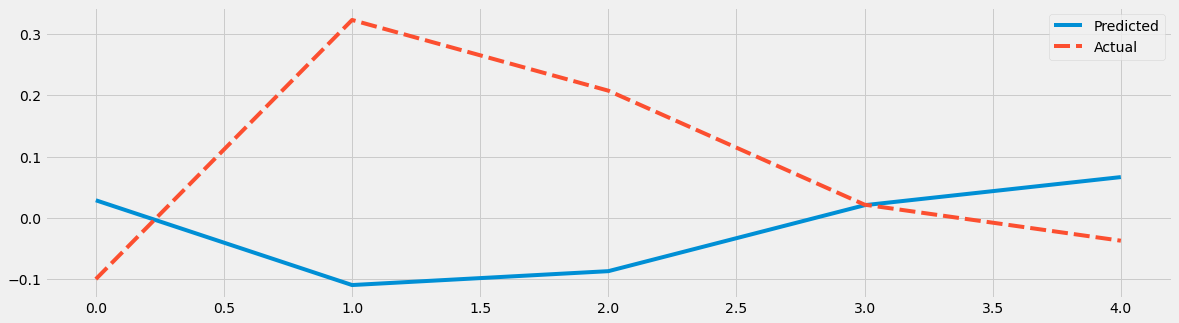


GOOGL
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-1756.042, Time=1.72 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=-1740.423, Time=1.33 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=-1766.708, Time=2.05 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=-1764.858, Time=2.86 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=-1735.097, Time=0.66 sec


KeyboardInterrupt: 

In [354]:
# SARIMAX forecast
for symbol in df['symbol'].unique()[:20]:
    print(f'\n{symbol}')
    df_temp = df[df['symbol']==symbol]
    df_reg = df_temp[['Close', 'RSI', 'PSAR', '%K', '%D', 'upper_band', 'lower_band', 'EWMA']]
    df_reg.dropna(inplace=True)
    df_reg = pd.concat([df_reg, final_df], axis=1)
    df_reg = df_reg.dropna()
    scaler = StandardScaler()
    scaler.fit(df_reg)
    df_reg1 = scaler.transform(df_reg)
    df_reg2 = pd.DataFrame(df_reg1, columns=df_reg.columns)
    
    for e in df_reg2.columns:
        diff = []
        result = adfuller(df_reg2[e])
        if result[1] < 0.05: # result[1] is the p-value; series is stationary
            pass
        else: # series is not stationary
            for i in range(1, len(df_reg2)):
                value = df_reg2[e][i] - df_reg2[e][i-1] # differenciate
                diff.append(value)
            diff.insert(0, 0) # fill 1st value with 0
            df_reg2[e] = diff # replace each variable by their differenciation
    
    X = df_reg2.drop('Close', axis=1)
    Y = df_reg2['Close']
    X_train, Y_train, X_test, Y_test = X[:-pred_days], Y[:-pred_days], X[-pred_days:], Y[-pred_days:]
    tss = TimeSeriesSplit(test_size=5)
    for train_index, test_index in tss.split(X,Y):
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index] 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    
    auto_model = auto_arima(Y_train.to_numpy(), exogenous=X_train.to_numpy(), m=2, seasonal=True,
                        suppress_warnings = True, step_wise=True, trace=True)           
    #print(auto_model.summary())
    
    model = SARIMAX(endog=Y_train.to_numpy(), exog=X_train.to_numpy().astype(float), 
                    order=(0, 0, 1),seasonal_order=(0, 0, 0, 2))
    model = model.fit(disp=False)
    #print(model.summary())
    result = model.predict(start=1, end=5, exog=X_test.to_numpy().astype(float))
    print(r2_score(result, Y_test))
    plt.figure(figsize=(18,5))
    sns.lineplot(data=pd.DataFrame({'Predicted':result,'Actual':Y_test.to_numpy()}))
    plt.show()

## 15) Serial Correlation of Residuals - Durbin Watson
* Test statistic of 2 indicates no serial correlation, 0 positive, 4 negative
* As a rule of thumb, test statistic values between 1.5 and 2.5 are considered normal

In [241]:
# Durbin Watson Test 
for symbol in df['symbol'].unique()[:1]: # just 1 stock
    df_temp = df[df['symbol']==symbol]
    df_reg = df_temp[['Close', 'RSI', 'PSAR', '%K', 'lower_band']]
    df_reg.dropna(inplace=True)
    for e in df_reg.columns:
        diff = []
        result = adfuller(df_reg[e])
        if result[1] < 0.05: # result[1] = p-value: series is stationary
            #df_reg[e] = np.log(df_reg[e])
            pass
        else: # series is not stationary
            #df_reg[e] = np.log(df_reg[e]) # log it either way
            for i in range(1, len(df_reg)):
                value = df_reg[e][i] - df_reg[e][i-1] # differenciate
                diff.append(value)
            diff.insert(0, 0) # fill 1st value with 0
            df_reg[e] = diff # replace each variable by their differenciation
    df_reg = pd.concat([df_reg, final_df], axis=1)
    df_reg = df_reg.dropna()
    model = VAR(df_reg)
    model_fitted = model.fit(1)
    out = durbin_watson(model_fitted.resid)
    for col, val in zip(df_reg.columns, out):
        print(col, ':', round(val, 2))
    print('\n')

Close : 1.95
RSI : 1.98
PSAR : 2.04
%K : 1.97
lower_band : 2.03
DEXJPUS : 1.96
DEXCAUS : 2.03
OBMMIC30YF : 1.97
DEXBZUS : 1.96
DEXCHUS : 2.03
DEXUSEU : 2.07
DEXKOUS : 2.02
DEXUSUK : 2.06
OBMMIJUMBO30YF : 2.16
DEXVZUS : 2.02
DEXMAUS : 2.09
SOFRINDEX : 2.05
DEXMXUS : 1.98
DPROPANEMBTX : 1.99
DEXTHUS : 1.98


<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['RSI', 'PSAR', '%K', 'lower_band', 'DEXJPUS', 'DEXCAUS', 'OBMMIC30YF', 'DEXBZUS', 'DEXCHUS', 'DEXUSEU', 'DEXKOUS', 'DEXUSUK', 'OBMMIJUMBO30YF', 'DEXVZUS', 'DEXMAUS', 'SOFRINDEX', 'DEXMXUS', 'DPROPANEMBTX', 'DEXTHUS'] do not Granger-cause Close: fail to reject at 5% significance level. Test statistic: 0.706, critical value: 1.588>, p-value: 0.817>


## 16) Benchmark Comparison - ARIMA

In [631]:
data = pd.DataFrame(pdr.DataReader(f'AAPL', 'yahoo', '2011-10-01','2022-01-01'))
data['Mean'] = (data['Low'] + data['High'])/2
data.tail(2)

High         Low        Open       Close      Volume  \
Date                                                                     
2021-12-30  180.570007  178.089996  179.470001  178.199997  59773000.0   
2021-12-31  179.229996  177.259995  178.089996  177.570007  64062300.0   

             Adj Close        Mean  
Date                                
2021-12-30  177.973251  179.330002  
2021-12-31  177.344055  178.244995

In [632]:
# preparing the dataset by shifting Open, Close, Low, & High by 1
steps=-1
dataset_for_prediction= data.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.dropna(inplace=True)
dataset_for_prediction.tail(2)

High         Low        Open       Close      Volume  \
Date                                                                     
2021-12-29  180.630005  178.139999  179.330002  179.380005  62348900.0   
2021-12-30  180.570007  178.089996  179.470001  178.199997  59773000.0   

             Adj Close        Mean      Actual  
Date                                            
2021-12-29  179.151749  179.385002  179.330002  
2021-12-30  177.973251  179.330002  178.244995

Text(0.5, 1.0, ' Apple  Stock Volume')

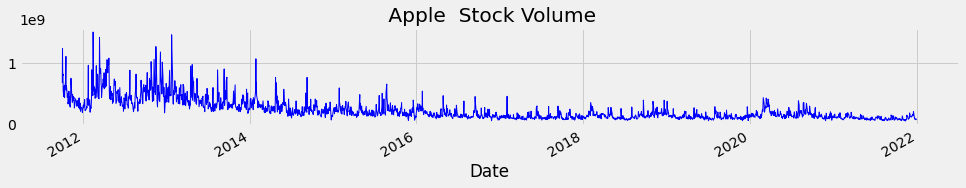

In [633]:
dataset_for_prediction['Volume'].plot(color='blue', figsize=(15,2), linewidth=1)
plt.title(" Apple  Stock Volume")

In [634]:
# normalizing input features
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High','Open', 'Close', 'Volume', 'Adj Close', 'Mean']])
scaled_input = pd.DataFrame(scaled_input)
X = scaled_input
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output = pd.DataFrame(scaler_output)
y = scaler_output

In [635]:
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Adj Close', 6:'Mean'}, inplace=True)
X= pd.DataFrame(X)
X.index=dataset_for_prediction.index
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_for_prediction.index

Low      High      Open     Close    Volume  Adj Close  \
Date                                                                      
2021-12-29  0.997649  0.991118  0.989344  0.994323  0.014571   0.994385   
2021-12-30  0.997347  0.990762  0.990178  0.987272  0.012813   0.987411   

                Mean  
Date                  
2021-12-29  0.996733  
2021-12-30  0.996403

In [637]:
train_size=int(len(data) *0.80)
test_size = int(len(data)) - train_size
print(test_size)

516


In [638]:
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [639]:
y_test=y['Stock Price next day'][:train_size].dropna()

In [640]:
step_wise=auto_arima(train_y, exogenous= train_X,
                     start_p=1,  start_q=1, 
                     max_p=6,  max_q=6, 
                     d=1, max_d=3,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)
step_wise.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18895.840, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18895.178, Time=0.95 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18897.801, Time=1.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18897.829, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18891.240, Time=1.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-18895.850, Time=2.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-18893.864, Time=3.91 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-18893.326, Time=3.75 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 17.067 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2064
Model:               SARIMAX(0, 1, 1)   Log Likelihood                9458.915
Date:                Wed, 02 Mar 2022   AIC                         -18897.829
Time:                        08:20:47   BIC                         -18841.510
Sample:                             0   HQIC                        -18877.182
                               - 2064                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001   5.72e-05      2.334      0.020    2.14e-05       0.000
Low           -0.0775      0.027     -2.878      0.004      -0.130      -0.025
High          -0.1088      0.027     -3.989      0.000      -0.162      -0.055
Open          -0.0334      0.025     -1.345      0.179      -0.082       0.015
Close          0.8236      0.280      2.946      0.003       0.276       1.372
Volume      4.254e-05      0.001      0.048      0.962      -0.002       0.002
Adj Close     -0.3138      0.292     -1.074      0.283      -0.886       0.259
Mean          -0.0936      0.020     -4.605      0.000      -0.133      -0.054
ma.L1         -0.0475      0.050     -0.957      0.339      -0.145       0.050
sigma2      6.085e-06   8.13e-08     74.798      0.000    5.93e-06    6.24e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7172.19
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.43   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.66e+17. Standard errors may be unstable.
"""

In [643]:
a=train_size+test_size-(steps)-train_size

In [645]:
model= SARIMAX(train_y, exog=train_X, order=(0,1,1), seasonal_order=(0, 0, 0, 2), enforce_invertibility=False, enforce_stationarity=False)
results = model.fit(method='bfgs')
predictions = results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)
forecast_1 = results.forecast(steps=test_size-1, exog=test_X)
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])

Optimization terminated successfully.
         Current function value: -4.606472
         Iterations: 31
         Function evaluations: 43
         Gradient evaluations: 43
515


In [648]:
forecast_apple = pd.DataFrame(forecast_1)
forecast_apple.reset_index(drop=True, inplace=True)
forecast_apple.index = test_X.index
forecast_apple['Actual'] = scaler_output.iloc[train_size:, 0]
forecast_apple.rename(columns={'predicted_mean':'Forecast'}, inplace=True)

In [649]:
forecast_apple

Forecast    Actual
Date                          
2019-12-16  0.340827  0.341431
2019-12-17  0.341553  0.341769
2019-12-18  0.340633  0.341102
2019-12-19  0.340963  0.341911
2019-12-20  0.340118  0.344466
...              ...       ...
2021-12-23  0.960436  0.992896
2021-12-27  0.984309  1.000000
2021-12-28  0.978103  0.996733
2021-12-29  0.978540  0.996403
2021-12-30  0.971882  0.989899

[515 rows x 2 columns]

<AxesSubplot:xlabel='Date'>

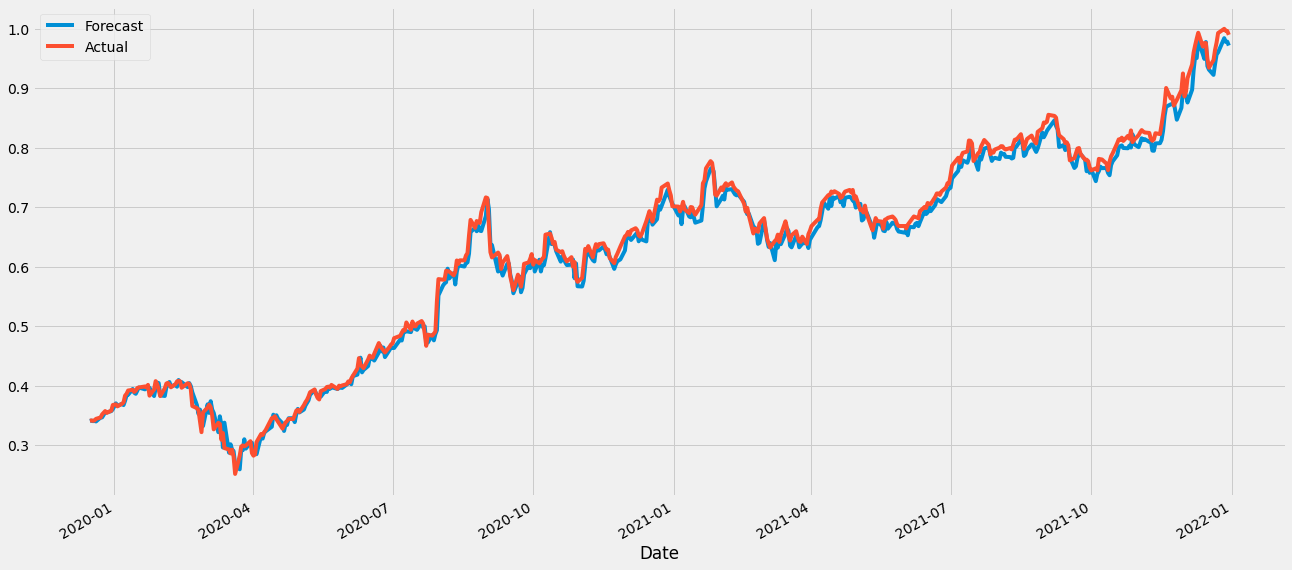

In [650]:
forecast_apple['Forecast'].plot(legend=True)
forecast_apple['Actual'].plot(legend=True)

In [652]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [654]:
r2_score(forecast_apple['Forecast'], forecast_apple['Actual'])

0.9933198292021135

In [655]:
# scale back
train_predict = sc_out.inverse_transform(predictions[['Pred']])
test_predict = sc_out.inverse_transform(predictions[['Actual']])